<center>

# Analysing Climate Datasets: a practical study of El Nino using SST reanalysis 

Climate Project Based Learning (PBL) i.e. APP Climat, 2023

ENSEEIHT MFEE 

Sulian Thual, Mercator-Ocean International

</center>

# Setup

We will execute this notebook in Google Colaboratory (hereafter Colab) and use Google Drive to store the data. You will need to have a google account. Before starting, you have to do the following manually:
- 1) login to google drive using your account [here](https://www.google.com/drive/)
- 2) in google drive, create a folder TPN7 in MyDrive/
- 3) Select TPN7, Share, Anyone with the Link, Editor (needed to overwrite files in the folder)

Below we mount the google drive and go the folder TPN7 which will be our working space. If you want to use another location, create the folder elsewhere and edit the "cd" to the new location in the cell below. Then we import relevant python libraries and define some custom functions.

In [ ]:
#@title
# mount the google
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
# go the folder 
%cd gdrive/MyDrive/TPN7

Mounted at /content/gdrive
/content/gdrive/MyDrive/TPN7


In [ ]:
#@title
# import python libraries we need

# for data treatment and maths
import numpy as np
import xarray as xr
import pandas as pd
# import netCDF4# not needed
# import numpy.ma as ma# masked arrays (not needed)
from sklearn.decomposition import PCA# for PCA (EOFS)

# for displays
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython import display# more display elements in notebook
from IPython.display import Image# display images in notebook
import warnings
warnings.simplefilter('ignore')# this removes simple warnings

# some tools
import sys# access to system
import inspect# to look at objects
import datetime# for datetime64 format (we dont really need it)

# this convert a  matplotlib animation to html for display
def anitohtml(ani,save=None):
    """ convert an animation to html """
    video= ani.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    plt.close()
    if save is not None:# specify save file (string)
        with open(save+".html", "w") as f_:
            print(ani.to_html5_video(), file=f_)



In [ ]:
#@title
# Did you do the all the steps above? is everything working? print yes to confirm
print('huh')

huh


# Introduction

In this notebook, we will analyze a major climate mode, the Niño Southern Oscillation (hereafter ENSO), in a climate reanalysis dataset. We begin with a brief introduction on what we will cover. 


<b>What is the ENSO</b>: The normal conditions in the Pacific (figure below) have warm sea surface temperatures (hereafter SST) in the west and cold sea surface temperatures in the east, whith also a circulation in the atmosphere and the ocean. During El Nino events, the warm water expand to the east and the circulation changes. During La Nina, the cold waters expand to the west and the circulation changes as well.


In [ ]:
#@title
Image(url="https://raw.githubusercontent.com/sulianthual/TPN7-ENSOSST/main/ENSO_sketch.png", width=1000)

The ENSO is a cycle where the positive phase is El Nino and the negative phase is La Nina. One way to measure it is with the ONI index that averages SST anomalies in the equatorial Pacific region (see figure below). The  strong El Nino events can have important societal and environmental impacts because all around the world. See another simple explanation from the ENSO blog [here](https://www.climate.gov/news-features/blogs/enso/what-el-ni%C3%B1o%E2%80%93southern-oscillation-enso-nutshell).


In [ ]:
#@title
Image(url="https://raw.githubusercontent.com/sulianthual/TPN7-ENSOSST/main/Nino34_sketch.png", width=800)


<b> ENSO dynamics and models</b>: The ENSO involves a coupling between the ocean and atmosphere. It is simulated by large models that cover the whole Earth (called general circulation models or GCMs), and also by simpler models.

With a background in fluid mechanics you have all the tools to understand the ENSO dynamics, although we will not detail them here. To prove you this, we show below the equations of the Cane-Zebiak model, a rather simple model that was the first to predict El Nino in 1987. Looks familiar? The model simulates only the Pacific region with a heat budget for the sea surface temperature (SST), a shallow-water model for the ocean and another shallow-water model for the atmosphere. These are slightly specific flows called geophysical flows that take into account Earth rotation. The scientific article that reviews this is [here](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/97JC03424) (no need to read it).

In [ ]:
#@title
Image(url="https://raw.githubusercontent.com/sulianthual/TPN7-ENSOSST/main/CZ_sketch.png", width=800)

<b>ERSSTv5 reanalysis</b>: In this notebook we will analyse the ENSO in sea surface temperature (SST) data (unfortunately we will not have time to look at multiple fields). We will get this SST from the ERSSTv5 reanalysis provided by NOAA (see figure below). The ERSSTv5 is a reanalysis, meaning a reconstruction of data from the past (1854 to today). To do this it uses past observations of various sources and blends them to reconstruct SST over the whole Earth. There are many sources of data where you could look at ENSO variability, but this is a simple example. 

In [ ]:
Image(url="https://psl.noaa.gov/data/gridded/images/small/ersstv5.png", width=600)


# Main goal

In the notebook we compute some diagnostics on the SST data that are relevant to ENSO, including Empirical Orthogonal Functions (EOFs). Your main goal should be to understand the general process such that you can do similar analysis on your own (e.g. in another dataset, or looking at another climate phenomena). There is no need to understand every piece of code in detail (it is sometimes too complicated or messy).

The general structure of the notebook is as follows:
- Prepare the data (download and prepare with package xarray)
- Decompose the signals (compute mean, seasonal, trend and anomalies)
- Analyse the ENSO (compute some standard metrics)
- Analyse the Empirical Orthogonal Functions (EOFs) on 1D data
- Analyse the EOFs on 2D data (a bit harder)
- Do a Take-home exercise

There is a summary at the end of each section which is basically what you need to remember.

We will use various python packages (matplotlib.pyplot, numpy, xarray, sklearn... ) that you may or may not be familiar with. We will not have time to detail them too much unfortunately. 



# Prepare the Data

In this section we download and prepare the SST data from ERSSTv5 reanalysis. We need to understand the data format (netcdf), do some simple checks and some small modifications. 




<b>Step 1</b>: download the data 


Below we import the ERSSTv5 climate reanalysis data from [here](https://psl.noaa.gov/data/gridded/data.noaa.ersst.v5.html). The data is downloaded as a single netcdf file around 93MB. After that, you should have the file sst.mnmean.nc on your drive (and you can cancel future executions with "if False"). 

In [ ]:
#@title
if False:
  # Download the dataset
  !wget https://downloads.psl.noaa.gov/Datasets/noaa.ersst.v5/sst.mnmean.nc


<b>Step 2</b>: import the data (netcdf).

The data is in the netcdf format. A netcdf (with extension .nc) is a file format for storing multidimensional scientific data that is very common for climate data. There are several python packages than can deal with the netcdf format, here we use the <b>xarray</b> package to import the data. The online documentation for xarray can be found [here](https://docs.xarray.dev/en/stable/) (no need to read it). 



In [ ]:
#@title
df=xr.open_dataset('sst.mnmean.nc')
print(df)

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 2029, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2023-01-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:    

Lets analyze the structure of the imported netcdf above. It stores a gridded sst variable $T(x,y,t)$ that depends on longitude ($x$), latitude ($y$) and time ($t$). Herefater we will note the gridded multidmensional array as $T_{i,j,k}$ with axis $x_{i}$, $y_{j}$, $t_{k}$ and with respective indices $0\le i\le N_{x}-1$ as well as $0\le j\le N_{y}-1$ and $0\le k\le N_{t}-1$. The main components of the netcdf file are:
- Dimensions (integers): the sizes of the axis $N_{x},N_{y},N_{t}$
- Variables (arrays): the multidimensional array $T_{i,j,k}$ and the one-dimensional arrays for the axis $x_{i},y_{j},t_{k}$. xarray separates these into coordinate variables (unidimensional) and data variables (multidimensional).
- Attributes (pairs of strings): annotations that provide additional information, each with a name and associated text. They can be global or specific to a variable.

Above in the netcdf we have the dimensions "lon", "lat" and "time". There is also the coordinates "lon", "lat" and "time" that store the axis arrays (they are not the same thing). The data variable "sst" is the multimensional array. There is also a variable "time_bnds" and a dimension "nv" that we will omit. The rest is attributes (title, description, comment...) that are global. 

<b>Step 3</b>: analyze the xarray dataset object (<b>optional</b>). 

Here, xarray has imported the content of the netcdf file in df as an "xarray Dataset", an object which we can manipulate. An object is a complex structure that can contain metadata of different types (called attributes), functions (called methods), other objects embedded in it, etc. Even if you dont really need to, you can try to understand what an object does with the following:
- look at the documentation: df?, help(df), online documentation or just google
- look at the object type (or class): type(df)
- look at the available methods (i.e. functions): dir(df)
- do many small tests and print everything...

Below we did some small tests to undertand the structure of the dataset object (no need to read it).

In [ ]:
#@title
# Some small tests you can do (for any object, method...):
# print('0 ')
# help(df)# look at the docstring
# df?
# print(type(df))# look at the type
# print(np.asarray(dir(df)))# list all available methods (as np array for text wrapping)
# print('1 ')
# print(df.dims)# an embedded object (that looks like a dictionary) holds dimensions
# print(df.dims['time'])# get a dimension size from its name
# print('2 ')
# print(type(df.coords))# an object for holding coordinates
# print(df.coords)
# print('3 ')
# print(type(df['lon']))# each coordinate is accessible as a DataArray object
# print(type(df['lon'].values))# it holds a numpy array
# print(df['lon'].values[0:4])
# # print(type(df.lon))# this is the same but each coordinate is embedded as a variable!
# # print(type(df.lon.values))
# # print(df.lon.values[0:4])
# print('4 ')
# print(type(df.data_vars))# an object for holding data variables
# print(df.data_vars)
# print('5 ')
# print(type(df.data_vars['sst']))# each data var is accessible as a DataArray object
# print(type(df.data_vars['sst'].values))# it holds a numpy array
# print(df.data_vars['sst'].values[0,0:4,0:4])
# # print(type(df.data_vars.sst))# this does not work the same way as coordinates, returns error

<b>Step 5</b>: Extract a DataArray from the Dataset.
 
 xarray has two main types of data structures: 
- a DataArray, which holds a single multi-dimensional variable and its coordinates
- a Dataset, which holds multiple variables that potentially share the same coordinates

Below we extract the SST variable from the dataset as a datarray. We do this because we only need the SST, and because a DatArray is simpler (it uses different methods than a Dataset). 

By doing so, we have lost some information from the initial Dataset such as the global attributes (title, description), the variable time_bdns and dimension nv. The DatArray has its own attributes (e.g. units in degree Celsius), these are annotations from the netcdf specific to the variable.



In [ ]:
#@title
df=df['sst']# extract sst only as a dataarray object
print(df)

<xarray.DataArray 'sst' (time: 2029, lat: 89, lon: 180)>
[32504580 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2023-01-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]


We can extract numpy arrays for the axis and multidimensional data, so we can plug them to more familiar routines like matplotlib. There are several ways to do this as shown below. 

1 
<class 'xarray.core.dataarray.DataArray'>
<class 'numpy.ndarray'>
2 
<class 'xarray.core.dataarray.DataArray'>
<class 'numpy.ndarray'>


Text(0.5, 1.0, 'SST at first timestep')

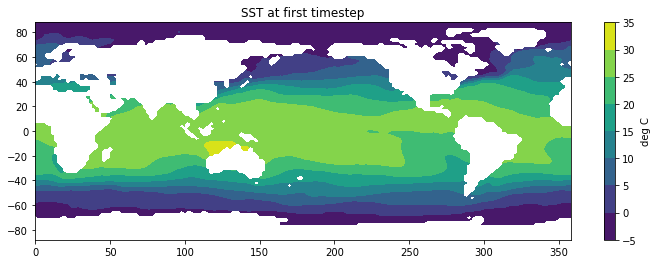

In [ ]:
#@title
# Get the embedded numpy arrays

# You can get the embedded numpy arrays in many ways
print('1 ')
print(type(df))# this is a data array
print(type(df.data))#points to numpy data
# print(type(df.values))#this is equivalent
# print(type(df.to_numpy()))#this is equivalent but called as function
print('2 ')
print(type(df.lon))# this is a data array
# print(type(df['lon']))# this is equivalent
print(type(df.lon.data))#points to numpy data
# print(type(df.lon.values))#this is equivalent
# print(type(df.lon.to_numpy()))#this is equivalent

# Lets extract a subset and contour it
xx=df['lon'].data
yy=df['lat'].data
dd=df.data[0,:,:]# access only first timestep
fig=plt.figure(None, figsize = (12, 4))
plt.contourf(xx,yy,dd)
plt.colorbar(label='deg C')
plt.title('SST at first timestep')

<b>Step 6</b>: Deal with bad values

Climate datasets typically have "bad values" that deal with missing data. Above we have seen that some points have a value "nan" for Not-a-Number: they correspond to the continents. Another type of bad value you may encounter in climate data is a mask (marked "$\text{--}$") or a flagged unphysical value (e.g. -1e+30), but we wont cover that here. 

The NaN values sometimes require special treatment: for example with numpy you will have to use np.nanmin(), np.nanmax(), np.nanmean() to skip bad values. xarray often does this automatically.

In [ ]:
#@title
# Check the min-max range of the data to see if it is consistent
print('1 ')
print(np.min(df.data),np.max(df.data))# this searches the min and max including over nans 
print(np.nanmin(df.data),np.nanmax(df.data))# min and max excluding nan values


1 
nan nan
-1.8 42.32636


<b>Step 7</b>: Check the axis.

Last step for pretreating data is to check the axis dimensions and units. Each axis (coordinate) inside the DataArray is itself a DataArray.

Below we print the longitude axis. The longitude axis is in degrees East ranging from 0E in increments of 2 deg, and it is periodic (0E=360E). Negative degree E are also referred to as degree W (e.g. 50W=-50E). The 0 deg E is the Greenwhich or prime meridien (London), 180E (or 180W) is the middle of the Pacific. We also call the longitudinal direction the zonal direction (from time zones). At the equator, 1 deg E corresponds to around 111km, but to a shorter distance closer to the poles due to the Earth being a sphere.


In [ ]:
#@title
# get some informations
print(df.lon)

# mylon=-80%360# this converts a 80W longitude into degree E using modulo 

<xarray.DataArray 'lon' (lon: 180)>
array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,  22.,
        24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,  44.,  46.,
        48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,  66.,  68.,  70.,
        72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,  88.,  90.,  92.,  94.,
        96.,  98., 100., 102., 104., 106., 108., 110., 112., 114., 116., 118.,
       120., 122., 124., 126., 128., 130., 132., 134., 136., 138., 140., 142.,
       144., 146., 148., 150., 152., 154., 156., 158., 160., 162., 164., 166.,
       168., 170., 172., 174., 176., 178., 180., 182., 184., 186., 188., 190.,
       192., 194., 196., 198., 200., 202., 204., 206., 208., 210., 212., 214.,
       216., 218., 220., 222., 224., 226., 228., 230., 232., 234., 236., 238.,
       240., 242., 244., 246., 248., 250., 252., 254., 256., 258., 260., 262.,
       264., 266., 268., 270., 272., 274., 276., 278., 280., 282., 284., 286.,
       288., 290

The latitude ranges from 88N to 88S with gridstep of 2 degree N. We also call the latitudional direction the meridional direction (from meridian). 1 deg N always corresponds to around 111km. Below we revert the latitude axis so it goes from 88S to 88N (it just makes selecting data slightly easier afterwards).

In [ ]:
#@title
# get some informations
print(df.lat)

# the axis goes from north to south, lets revert that
df=df.reindex(lat=np.sort(df.lat))# revert indexing along one dimension
print('2 ')
print(df.lat.data[0:4])# check it worked on 5 first elements

<xarray.DataArray 'lat' (lat: 89)>
array([ 88.,  86.,  84.,  82.,  80.,  78.,  76.,  74.,  72.,  70.,  68.,  66.,
        64.,  62.,  60.,  58.,  56.,  54.,  52.,  50.,  48.,  46.,  44.,  42.,
        40.,  38.,  36.,  34.,  32.,  30.,  28.,  26.,  24.,  22.,  20.,  18.,
        16.,  14.,  12.,  10.,   8.,   6.,   4.,   2.,   0.,  -2.,  -4.,  -6.,
        -8., -10., -12., -14., -16., -18., -20., -22., -24., -26., -28., -30.,
       -32., -34., -36., -38., -40., -42., -44., -46., -48., -50., -52., -54.,
       -56., -58., -60., -62., -64., -66., -68., -70., -72., -74., -76., -78.,
       -80., -82., -84., -86., -88.], dtype=float32)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
Attributes:
    units:               degrees_north
    long_name:           Latitude
    actual_range:        [ 88. -88.]
    standard_name:       latitude
    axis:                Y
    coordinate_defines:  center
2 
[-88. -86. -84. -82.]


Finally, time axis is monthly and in the datetime64 format (a string specifying exact date). The datetime64 format has extended functionalities compared to a regular array (see [here](https://docs.xarray.dev/en/stable/user-guide/time-series.html)), it is also compatible with matplotlib and numpy but needs additional workarounds. 

Below we add a new time axis to the datarray, called "time_in_years", that is a regular numpy array in years. We will use it when we want to treat time just like any other axis. 

In [ ]:
#@title
print(df.time)# check the time axis

# add a regular time array in years
time_in_years_data=df.time.dt.year.data+(df.time.dt.month.data)/12+df.time.dt.day.data/365# create a time axis in years
df=df.assign_coords(time_in_years=("time", time_in_years_data))# add it as new coordinate (with dimension time)
df.time_in_years.attrs['units']='years'# add some comments to the coordinate
print('2 ')
print(df.time_in_years.data[0:4])# check first five elements

<xarray.DataArray 'time' (time: 2029)>
array(['1854-01-01T00:00:00.000000000', '1854-02-01T00:00:00.000000000',
       '1854-03-01T00:00:00.000000000', ..., '2022-11-01T00:00:00.000000000',
       '2022-12-01T00:00:00.000000000', '2023-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2023-01-01
Attributes:
    long_name:        Time
    delta_t:          0000-01-00 00:00:00
    avg_period:       0000-01-00 00:00:00
    prev_avg_period:  0000-00-07 00:00:00
    standard_name:    time
    axis:             T
    actual_range:     [19723. 81449.]
2 
[1854.08607306 1854.16940639 1854.25273973 1854.33607306]


We detail below a few tests below on the datetime64 format (no need to read it).

In [ ]:
#@title
# print('1 ')
# print(df.time)# time is a dataarray in format datetime64
# print(df.time.data[0:4])# datetime64 is a string of date (cant sum it directly)
# print('2 ')
# print(datetime.datetime(2000,1,1))# this is a datetime format (not 64!)
# print(pd.to_datetime(["2000-01-01"]))# this is a datetime64 format
# print(pd.date_range("2000-01-01", periods=365))# this is a datetime64 daily array
# print('3 ')
# print(df.sel(time=slice("2000-06-01", "2000-06-10")))# this is a time slice
# print(df.isel(time=0))# this still works too
# print('4 ')
# print(df.time.dt.year.data)# this gives the year
# print(df.time.dt.month.data)# this gives the month 
# print(df.time.dt.day.data)# this gives the day
# print(df["time.month"].data)# this is equivalent
# print(df["time.season"].data)# current season
# print(df.time.dt.dayofweek.data)# day of week
# print('5 ')
# print(df.time.dt.year.data+(df.time.dt.month.data)/12+df.time.dt.day.data/365)# this convert to a numpy in years
# print(df["time"].dt.floor("D").data)# this rounds to daily value
# print(df.indexes['time'].normalize()[0:4])# this replace axis with a simpler year-month-day axis
# print('6 ')
# Lets make a plot
# dfs=df.sel(latitude=-0.5,time=slice('1997-01-01','1999-01-01'))# take a subset
# fig=plt.figure(None, figsize = (12, 4))# data now centered on Pacific
# plt.contourf(dfs.longitude,dfs.time,dfs.data)
# plt.colorbar()
# plt.title('SST at equator (0N) during 1997-1998')

<b>Step 8</b>: take a subset if necessary.

We may want to take a subset of the data to focus on a region or a period, or simply to reduce the size (climate data can be very big). Below we show example of selecting a subset region and one timestep with xarray.

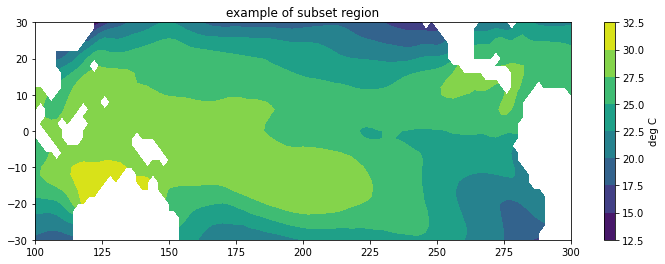

In [ ]:
#@title
# we can select a subset from the axis ranges with sel
df_subset=df.sel(lon=slice(100,300),lat=slice(-30,30))# selects a slice in longitude from 100E to 300, and in latitude from 30S to 30N
# print(df.sel(lon=slice(300,100)))# this will not work, you must give values in increasing order as they appear in the axis

# We can also select an exact value (but it must exist)
# print(df.sel(lat=-0.5))# this wont work as latitude=-0.5 dont exist
# print(df.sel(lat=0))# this will work as latitude=0 exists
# print(df.sel(lat=-0.5,method='nearest'))# this will always work as will look for closest latitude

# we can also select by python indices (starting at 0), e.g. taking only first timestep
df_subset=df_subset.isel(time=0)
# df_subset=df_subset[0,:,:]# this works too 

# You can chain slicing (or any xarray operations), result is the same as above
# df_subset=df.sel(lon=slice(100,300),lat=slice(-30,30)).isel(time=0)
# print(df_subset)# always good to check what the result looks like

fig=plt.figure(None, figsize = (12, 4))
plt.contourf(df_subset.lon,df_subset.lat,df_subset.data)
plt.colorbar(label='deg C')
plt.title('example of subset region')

del df_subset# delete for memory

For the remainder of the notebook, we will consider a subset of the data with only the period 1960-2022 (62 years). For time in datetime64, you need to input strings with data (year, month, day is sufficient). You can optionally save your subset in a new netcdf for quicker reuse later (no need to do it here).

In [ ]:
# take only the period 1980-2022
df=df.sel(time=slice('1960-01-01','2022-01-01'))

# optional: save in a new netcdf (no need to do this in this notebook)
# df.to_netcdf('sst.mnmean_subset.nc')

<b>Step 9</b>: Summary

We have now finished treating the initial data. Below we repeat all the steps one more time as a single function we can recall later.

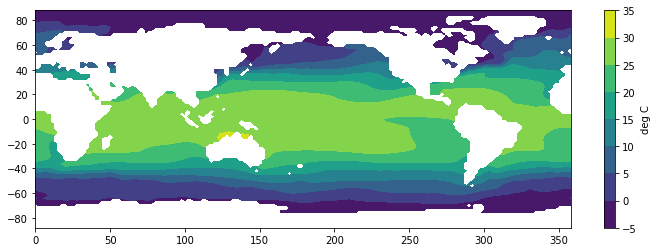

In [ ]:
#@title


def getmysst():
  # read the data
  df=xr.open_dataset('sst.mnmean.nc')# import netcdf data as a xarray dataset
  df=df['sst']# extract sst only as a dataarray object
  # print(df)# some optional checks

  # check potential bad values
  # print(np.nanmin(df.data),np.nanmax(df.data))# min and max excluding nan values

  # revert latitude axis so it goes north (optional)
  df=df.reindex(lat=list(reversed(df.lat)))

  # add an optional time axis in years
  time_in_years_data=df.time.dt.year.data+(df.time.dt.month.data)/12+df.time.dt.day.data/365# create a time axis in years
  df=df.assign_coords(time_in_years=("time", time_in_years_data))# add it as new coordinate (with dimension time)
  df.time_in_years.attrs['units']='years'# add some annotations to the coordinate

  # optional: take a subset
  df=df.sel(time=slice('1960-01-01','2022-01-01'))

  # optional: save as another netcdf for later
  # df.to_netcdf('sst.mnmean_subset.nc')

  return df

# call the function
df=getmysst()

# do a contour of first timestep just for test
fig=plt.figure(None, figsize = (12, 4))
plt.contourf(df.lon,df.lat,df.data[0,:,:])
plt.colorbar(label='deg C')



<b>Exercises</b>:
- The current data file is 93MB for a spatial resolution of 2x2 deg and over 1854-2022. Climate models typically use higher resolutions, e.g. at 1/4 or 1/12 deg, and they include fields in the ocean and atmosphere at multiple vertical levels (they also use different grids, e.g. spherical, tripolar). What file size would we expect for ocean temperature on 42 vertical levels at a 1/4x1/4 resolution? at a 1/12x1/12 resolution? 
- Contour a map the SSTs around Australia for the last timestep of the data (the first index of an array in python is noted 0, and the last index -0). Write you answer in a cell below



<b>Answers</b>:
Write your answer here

In [ ]:
# Write your code here

# Decompose the Signals



The ocean and atmosphere variability occurs on a wide range of spatial and temporal scales (see e.g. [here](http://www-das.uwyo.edu/~geerts/cwx/notes/chap01/marine.html)). Climate variability is only the low-frequency part of this variability, as opposed to e.g. weather. In this section, we will decompose our SST data into a sum of obvious signals: mean, seasonal variations, trend and anomalies. Once we have separateed these obvious signals, we can focus on less obvious climate signals such as the ENSO (that will appear in the anomalies).

In [ ]:
# load the data (we will keep it in memory hereafter)
df=getmysst()

<b>Step 1</b>: Do some preliminary visualization.


Below we animate SST with time for 2000 to 2002. Major SST variations are the north-south displacement of warm waters with seasons (following the sun).  

In [ ]:
#@title
%%time

#################### Non need to understand this part
# Animate two years of data

# Setup the figure
fig = plt.figure(None,figsize=(12,6),dpi=50)# keep it small with dpi
plt.subplots_adjust(top=0.95, bottom=0.05, right=0.95, left=0.05, hspace=0, wspace=0)# margins

# prepare the data
dfs=df.sel(time=slice('2000-01-01','2002-01-01'))
frames=len(dfs.time)# length of animation


# function for what to display each frame
def animate(frame):
    display.clear_output(wait=True)
    print(frame+1,'/',frames)
    plt.clf()# clear the frame
    plt.contourf(dfs.lon,dfs.lat,dfs.data[frame,:,:],levels=np.linspace(-4,32,10))
    plt.colorbar(label='C')
    plt.title(str(dfs.time.data[frame]).partition('T')[0])
    # plt.title(str(df.time.dt.year.data[frame])+'-'+str(df.time.dt.month.data[frame]))# could also use this

# Create the animation object
ani = FuncAnimation(fig, animate,frames=frames, interval=200, blit=False, repeat=True)# dont blit if contourf!
anitohtml(ani)

del dfs# delete for memory


25 / 25


CPU times: user 6.6 s, sys: 259 ms, total: 6.86 s
Wall time: 7.37 s


<b>Step 2</b>: compute the temporal mean

The temporal mean for the gridded data reads:

$\overline{T}_{i,j}=\frac{1}{N_{t}}\sum_{k=1}^{N_{t}} T_{i,j,k}$

where $N_{t}$ is the number of timesteps. The mean is shown below: waters are warmer at the equator due to the increased insolation, but not evenly due to ocean [currents](https://en.wikipedia.org/wiki/Ocean_current) that displace the waters. For example the eastern Pacific is colder than the western Pacific. 

Text(0.5, 1.0, 'SST MEAN')

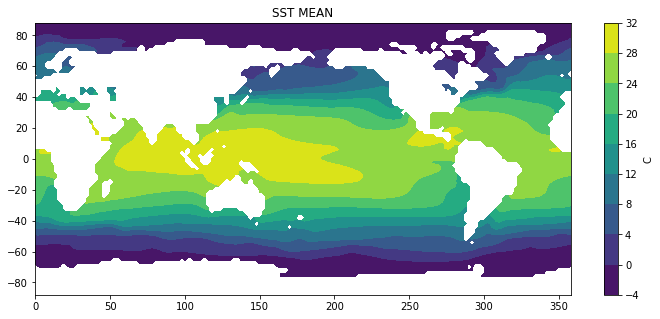

In [ ]:
#@title
# compute the temporal mean
fig=plt.figure(None, figsize = (12, 5))
plt.contourf(df.lon,df.lat,df.mean("time").data)# mean along time axis (omitting nan values automatically)
plt.colorbar(label='C')
plt.title('SST MEAN')

<b>Step 3</b>: compute the climatology

We have seen that the most important SST variations are from the seasonal cycle. The climatology $T^{C}(x,y,m)$ is the average conditions at a given time of the year (here the month $m$). The formula for the climatology is given as an exercise hereafter. 

Below we compute the climatology with xarray by grouping and averaging data by month of the year. It shows movements of SST from north to south with season (following the sun). 

In [ ]:
#@title
%%time

# compute the climatology
dfc=df.groupby("time.month").mean("time")# mean along time axis (omitting nan values automatically)

#################### Non need to understand this part
# Animate 
# Setup the figure
fig = plt.figure(None,figsize=(12,6),dpi=50)# keep it small with dpi
plt.subplots_adjust(top=0.95, bottom=0.05, right=0.95, left=0.05, hspace=0, wspace=0)# margins

# prepare the data
frames=len(dfc.month)# length of animation

# function for what to display each frame
def animate(frame):
    display.clear_output(wait=True)
    print(frame+1,'/',frames)
    plt.clf()# clear the frame
    plt.contourf(dfc.lon,dfc.lat, dfc.data[frame,:,:],levels=np.linspace(-4,32,10),extend='both')
    plt.colorbar(label='C')
    plt.title("MONTH="+str(dfc.month.data[frame]))
    # plt.title(str(df.time.dt.year.data[frame])+'-'+str(df.time.dt.month.data[frame]))# could also use this

# Create the animation object
ani = FuncAnimation(fig, animate,frames=frames, interval=200, blit=False, repeat=True)# dont blit if contourf!
anitohtml(ani)

del dfc# delete it from memory

12 / 12


CPU times: user 4.25 s, sys: 1.93 s, total: 6.18 s
Wall time: 4.75 s


<b>Step 4</b>: plot the data without seasonal variations

We can decompose our SSTs as follows:

$$T(x,y,t)=T^{C}(x,y,m)+T^{A}(x,y,t)$$

where $T^{C}$ is the climatology, and $T^{A}$ is called anomalies. By construction, the climatology has the same temporal mean as the data ($\overline{T^{C}}=\overline{T}$) and the anomalies are centered on zero ($\overline{T^{A}}=0$). By separating the climatology, we can analyze other signals on the anomalies. 

Below we compute the anomalies (xarray does this very easily). Then, we animate anomalies over the period 1996-1999 (1999 is included). We see a very large warming of around 5C in the eastern Pacific at the end of 1997: that is the most intense El Nino event on record, the 1997/1998 event. It is follow by a La Nina with cooling in 1999. 

In [ ]:
#@title
%%time

# compute the anomaly by removing the climatology
dfa=df.groupby('time.month')-df.groupby("time.month").mean("time")# group both by month to avoid creating extra dimension "month"
# print(dfa)

# Animate two years of data

# Setup the figure
fig = plt.figure(None,figsize=(12,6),dpi=50)# keep it small with dpi
plt.subplots_adjust(top=0.95, bottom=0.05, right=0.95, left=0.05, hspace=0, wspace=0)# margins

# take a subset
dfa=dfa.sel(time=slice('1996-01-01','2000-01-01'))
frames=len(dfa.time)# length of animation

# function for what to display each frame
def animate(frame):
    display.clear_output(wait=True)
    print(frame+1,'/',frames)
    plt.clf()# clear the frame
    plt.contourf(dfa.lon,dfa.lat,dfa.data[frame,:,:],levels=np.linspace(-5,5,11),extend='both',cmap='coolwarm')# be sure to keep levels the same
    plt.colorbar(label='C')
    plt.title('SSTA '+str(dfa.time.data[frame]).partition('T')[0])
    # plt.title(str(df.time.dt.year.data[frame])+'-'+str(df.time.dt.month.data[frame]))# could also use this

# Create the animation object
ani = FuncAnimation(fig, animate,frames=frames, interval=200, blit=False, repeat=True)# dont blit if contourf!
anitohtml(ani)

del dfa

49 / 49


CPU times: user 15.6 s, sys: 7.35 s, total: 23 s
Wall time: 16.2 s


A more general decomposition than the above reads:

$T(x,y,t)=\overline{T}(x,y)+T^{S}(x,y,m)+T^{A}(x,y,t)$

where $T$ is the total signal, $\overline{T}$ is the mean, $T_{S}$ is seasonal variations (centered on zero), and $T_{A}$ is anomalies (centered on zero). The climatology from before reads $T^{C}=\overline{T}+T^{S}$. 

Another field you can consider is $T^{MA}=\overline{T}+T^{A}$, which you can think of it as "totals with seasonal variations filtered out". Below we animate $T^{MA}$ and $T^{A}$ for the period 1996-1999. You can see on $T^{MA}$ that the western part of the Pacific is warmer than the eastern part, but that during the El Nino of 1997/1998 the warm waters expand all the way to the east.

In [ ]:
#@title
%%time

# compute anomalies
dfa=df.groupby('time.month')-df.groupby("time.month").mean("time")

# This is mean+anomalies (equivalent to totals with seasonal variations removed) 
dfam=dfa+df.mean("time")

# This is Ts (Tc-Tmean) (equivalent to totals with seasonal variations removed) 
# dfc=df.groupby("time.month").mean("time")
# dfs=dfc-df.mean("time")

############################# no need to understand this
# Animate two years of data

# Setup the figure
fig = plt.figure(None,figsize=(18,6),dpi=50)# keep it small with dpi
plt.subplots_adjust(top=0.95, bottom=0.05, right=0.95, left=0.05, hspace=0, wspace=0)# margins

# prepare the data
dfs1=dfam.sel(time=slice('1996-01-01','2000-01-01'))
dfs2=dfa.sel(time=slice('1996-01-01','2000-01-01'))
frames=len(dfs1.time)# length of animation

# function for what to display each frame
def animate(frame):
    display.clear_output(wait=True)
    print(frame+1,'/',frames)
    plt.clf()# clear the frame
    #
    plt.subplot(1,2,1)
    plt.contourf(dfs1.lon,dfs1.lat,dfs1.data[frame,:,:],levels=np.linspace(22,31,10),extend='both')# be sure to keep levels the same
    plt.colorbar(label='C',orientation='horizontal')
    plt.title('SSTA+MEAN '+str(dfs1.time.data[frame]).partition('T')[0])
    # plt.title(str(df.time.dt.year.data[frame])+'-'+str(df.time.dt.month.data[frame]))# could also use this
    #
    plt.subplot(1,2,2)
    plt.contourf(dfs2.lon,dfs2.lat,dfs2.data[frame,:,:],levels=np.linspace(-5,5,11),extend='both',cmap='coolwarm')# be sure to keep levels the same
    plt.colorbar(label='C',orientation='horizontal')
    plt.title('SSTA '+str(dfs2.time.data[frame]).partition('T')[0])
    # plt.title(str(df.time.dt.year.data[frame])+'-'+str(df.time.dt.month.data[frame]))# could also use this

from matplotlib.animation import FuncAnimation# to create
# Create the animation object
ani = FuncAnimation(fig, animate,frames=frames, interval=200, blit=False, repeat=True)# dont blit if contourf!
anitohtml(ani)# convert it to html for display

del dfs1,dfs2,dfam,dfa# for memory

49 / 49


CPU times: user 26.5 s, sys: 690 ms, total: 27.2 s
Wall time: 27.5 s


<b> Step 5</b>: compute the trend

Another strong signal in climate data is climate global warming that shows roughly as a trend in temperatures (and other quantities). There are several ways you can compute the trend, here we will just use a linear fit (i.e. a polynomial least-square fit of order 1). The expression of the trend for our data is thus:

$T^{D}(x,y,t)=a(x,y)t+b(x,y)$

where $a$ and $b$ are computed from linear fit to $T^{A}$ (we fit $T^{A}=at+b$ at each longitude and latitude). The reason we separate the trend is again to focus on other climate signals.

Below we show the evolution of global mean SSTA (the SSTA averaged over all longitudes and latitudes) as well as its trend. If instead you look at trends at each longitude and latitude, there are uneven: there is stronger warming in northern hemisphere, and there is even slight cooling near southern pole. The standard indicator of global warming is [global surface temperature](https://en.wikipedia.org/wiki/Global_surface_temperature) (slightly different as it averages SST over ocean and surface air temperature over land).  

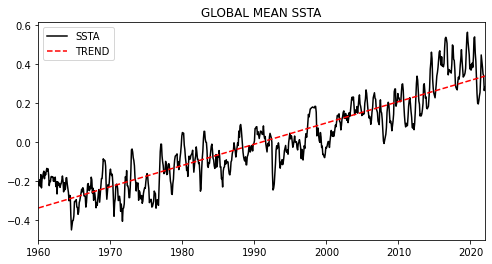

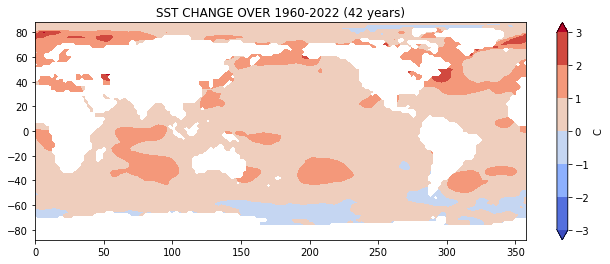

In [ ]:
#@title
# start with the df array at the end of "get the data" section

# compute the anomaly by removing the climatology
dfa=df.groupby('time.month')-df.groupby("time.month").mean("time")# group both by month to avoid creating extra dimension "month"

# compute the data trend (this will only work for datarray in the form time,lat,lon)
# note: xarray polyfit/polyval didnt work here so made a numpy approach
def mytimetrend(dfa):
  dfatrend=dfa.copy()
  t_=np.linspace(0,len(dfa.time.data)-1,len(dfa.time.data))
  nx=len(dfatrend.lon)
  ny=len(dfatrend.lat)
  for i in range(nx):
    for j in range(ny):
      p_=np.polyfit(t_, dfa.data[:,j,i], 1)
      dfatrend.data[:,j,i]=np.polyval(p_,t_)# save the trend
  return dfatrend

# Compute the trend as the linear fit data (it has same shape as ssta)
dfatrend=mytimetrend(dfa)

# detrend the data
# dfadetrend=dfa-dfatrend

fig=plt.figure(None,figsize=(8,4))
plt.plot(dfa.time,dfa.mean('lon').mean('lat').data,'k-',label='SSTA')
plt.plot(dfa.time,dfatrend.mean('lon').mean('lat').data,'r--',label='TREND')
plt.legend(loc=2)
plt.margins(x=0)
plt.title('GLOBAL MEAN SSTA')

fig=plt.figure(None, figsize = (11, 4))
plt.contourf(df.lon,df.lat,dfatrend.sel(time='2022-01-01')-dfatrend.sel(time='1960-01-01'),cmap='coolwarm',levels=np.linspace(-3,3,7),extend='both')
plt.colorbar(label='C')
plt.title('SST CHANGE OVER 1960-2022 (42 years)')

del dfatrend, dfa



<b>Step 6:</b> Summary

In this section we have extracted the mean, seasonal variations and trend, and can now focus on the anomalies that correspond to other climate signals (such as the ENSO). The decomposition of our data reads: 
$$T(x,y,t)=\overline{T}(x,y)+T^{S}(x,y,m)+T^{D}(x,y,t)+T^{A}(x,y,t)$$
where $\overline{T}$ is the temporal mean, $T^{S}$ is the seasonal variations (centered on zero), $T^{D}$ is the trend (centered on zeros), and $T^{A}$ is the detrended anomalies (centered on zeros). We can compute and extract each signal one after the other from left to right. 

Below we repeat all the main steps and define a function to get SSTA that we can recall later.

In [ ]:
#@title
# start with the df array at the end of "get the data" section

# do some naive visualizations (movies, plots, contours)

# compute the climatology (average conditions at given time of the year)
dfc=df.groupby("time.month").mean("time")

# compute the anomaly by removing the climatology
dfa=df.groupby('time.month')-df.groupby("time.month").mean("time")# group both by month to avoid creating extra dimension "month"

# you can compute "totals" without seasonal variations by summing temporal mean+anomalies
dfam=dfa+df.mean("time")

# detrend the data
dfa=dfa-mytimetrend(dfa)

# A function that gives detrended anomalies 
def getmyssta():
  df=getmysst()
  dfa=df.groupby('time.month')-df.groupby("time.month").mean("time")# anomalies
  dfa=dfa-mytimetrend(dfa)# detrend
  return dfa

del dfc,dfa,dfam# free from memory (we will recompute them later if needed)

<b>Exercises</b>: 

Consider a monthly timeserie of SST data at a single location: $T(t)$ where $t$ is time. Notations here are different from the rest of the notebook. The data is discrete, which we note $T(t)=T_{k}$ along with $t=k\Delta t$, $k=0,1,...,N-1$. $\Delta t$ is the monthly timestep and $N$ is the number of timesteps for a total of ten years of data. The arithmetic mean of $T$ over the entire timeserie reads:

$\overline{T}= \frac{1}{N} \sum_{k=0}^{N-1} T_{k}$

Questions:
 - what is the value of $N$?
 - let $m=0,..,N_{M}-1$ be the month of the year (with $N_{M}$=12) and $j=0,...,N_{Y}-1$ the current year (with $N_{Y}=10)$. Express $k$ in terms of $j$ and $m$. 
 - Write the expression for monthly climatology $T^{C}_{m}$ using all the above. 



Write you answer here!



# Analyse the ENSO

Now we analyse the El Nino Southern Oscillation in the data. For this, we compute the Nino 3.4 SST index and other common metrics. I also add some optional plots at the end to give more details about the ENSO. 



<b>Step 1</b>: compute the Nino 3.4 SST index

We have seen above that during El Nino events, the central and eastern Pacific is warmer than usual. The opposite happens during La Nina. One standard index that measures these changes is the Nino 3.4 SST index (also called ONI index), defined as the 3-month running mean of sea surface temperature (SST) anomalies in the Niño 3.4 region (170W-120W, 5N-5S). Below we compute and plot the index, which looks like an irregular oscillation. 

Note: the 3-month running mean or [moving average](https://en.wikipedia.org/wiki/Moving_average) is a type of low-frequency filter that removes fast fluctuations. However, we don't really need it here as our monthly data is already very smooth. 


In [ ]:
#get the SSTA (we will keep this in memory)
df=getmysst()
dfa=getmyssta()

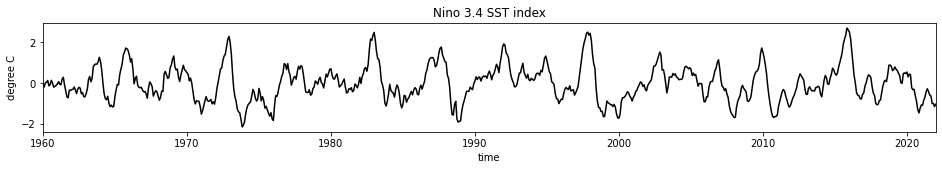

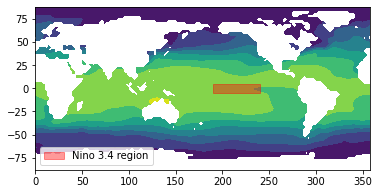

In [ ]:
#@title
# compute compute Nino 3.4 SST as a region average
# we first restrict data to the region, then we average over dimensions longitude and latitude
# everything can be chained with "." in one long sequence, as each operation returns the next object to operate on
dfn34=dfa.sel(lon=slice(-170%360,-120%360),lat=slice(-5,5)).mean("lon").mean("lat")
# print(dfn34)

# plot 
fig=plt.figure(None,figsize=(16,2))
fig.tight_layout()
plt.plot(dfn34.time,dfn34.data,'k-')
plt.title('Nino 3.4 SST index')
plt.ylabel('degree C')
plt.xlabel('time')
plt.margins(x=0)

fig=plt.figure(None,figsize=(6,3))
plt.contourf(df.lon,df.lat,df[0,:,:])
plt.fill_between([-170%360,-120%360],[-5,-5],[5,5],color='red',alpha=0.4,label='Nino 3.4 region')
plt.legend(loc=3)


<b>Step 2</b>: Classify conditions using the index.

The Nino 3.4 SST index is used operationally to monitor the state of the equatorial Pacific and lauch ENSO alerts. The standard definition an El Niño event is five consecutive months of Nino 3.4 SST above the threshold of +0.5°C (see [here](https://www.ncei.noaa.gov/access/monitoring/enso/sst)). The standard definition of a La Niña is five consecutive months below -0.5°C. Below we show a slightly simpler classification with the criteria of being above/below +-0.5°C. 

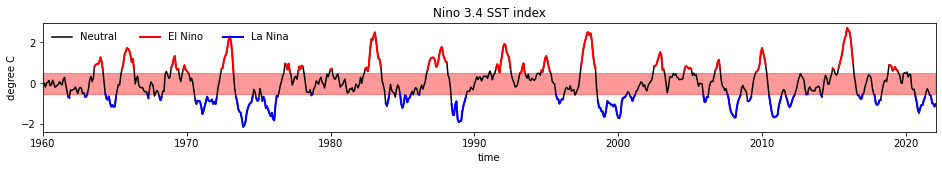

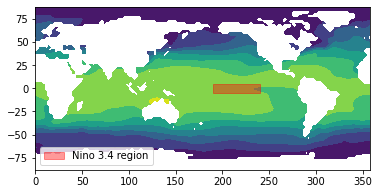

In [ ]:
#@title

# compute the region average
dfn34=dfa.sel(lon=slice(-170%360,-120%360),lat=slice(-5,5)).mean("lon").mean("lat")

# plot indicating El Nino, La Nina or neutral conditions 
fig=plt.figure(None,figsize=(16,2))
fig.tight_layout()
plt.plot(dfn34.time_in_years.data,dfn34.data,'k-',label='Neutral ')# I am using the time_in_years axis because it is easier to add more lines
plt.plot(dfn34.time_in_years.data,dfn34.where(dfn34>=0.5,other=np.nan).data,'r-',linewidth=2,label='El Nino')# only Nino
plt.plot(dfn34.time_in_years.data,dfn34.where(dfn34<=-0.5,other=np.nan).data,'b-',linewidth=2,label='La Nina')# only Nina
plt.fill_between([1960,2022],[-0.5,-0.5],[0.5,0.5],color='red',alpha=0.4,label='_nolegend_')# the treshold
plt.legend(loc='upper left',ncol=3,frameon=False)
plt.title('Nino 3.4 SST index')
plt.ylabel('degree C')
plt.xlabel('time')
plt.margins(x=0)

fig=plt.figure(None,figsize=(6,3))
plt.contourf(df.lon,df.lat,df[0,:,:])
plt.fill_between([-170%360,-120%360],[-5,-5],[5,5],color='red',alpha=0.4,label='Nino 3.4 region')
plt.legend(loc=3)


Below we animate SSTA for the period 1996-1999. You can see how the index measures the warming from the El Nino 1997/98 and cooling from the La Nina 1998/1999.

In [ ]:
#@title
%%time

# Animate two years of data (no need to understand code below!)

# Setup the figure
fig = plt.figure(None,figsize=(18,6),dpi=50)# keep it small with dpi
plt.subplots_adjust(top=0.95, bottom=0.05, right=0.95, left=0.05, hspace=0, wspace=0.1)# margins

# take a subset
dfs=dfa.sel(time=slice('1996-01-01','2000-01-01'))
dfn34=dfs.sel(lon=slice(-170%360,-120%360),lat=slice(-5,5)).mean("lon").mean("lat")# compute Nino 3.4 index
frames=len(dfs.time)# length of animation

# function for what to display each frame
def animate(frame):
    display.clear_output(wait=True)
    print(frame+1,'/',frames)
    plt.clf()# clear the frame
    plt.subplot(1,2,1)
    plt.contourf(dfs.lon,dfs.lat,dfs.data[frame,:,:],levels=np.linspace(-5,5,11),extend='both',cmap='coolwarm')
    plt.colorbar(label='C',orientation='horizontal')
    plt.plot([-170%360,-120%360,-120%360,-170%360,-170%360],[-5,-5,5,5,-5],'k--')# draw the region box

    plt.title('SSTA '+str(dfa.time.data[frame]).partition('T')[0])
    plt.subplot(1,2,2)
    plt.plot(dfn34.time_in_years.data,dfn34.data,'k-')
    plt.plot(dfn34.time_in_years.data[frame],dfn34.data[frame],'ro',markersize=20)
    plt.fill_between([1980,2022],[-0.5,-0.5],[0.5,0.5],color='red',alpha=0.4)
    cb=plt.colorbar(label='C',orientation='horizontal')# fake colorbar for spacing
    cb.remove()
    plt.title('Nino 3.4 SST index (deg C)')
    plt.gca().tick_params(axis='both', which='major', labelsize=15)
    plt.margins(x=0)
    plt.xlim([1996,2000])


# Create the animation object
ani = FuncAnimation(fig, animate,frames=frames, interval=200, blit=False, repeat=True)# dont blit if contourf!
anitohtml(ani)
# ani(10)# test one frame

del dfn34,dfs

49 / 49


CPU times: user 20.6 s, sys: 474 ms, total: 21.1 s
Wall time: 21.4 s
Compiler : 144 ms


<b>Step 3</b>: Look at the event composites (<b>optional</b>).

Now that we have computed the index Nino 3.4 SST, we can see how it relates to the spatial structure of El Nino and La Nina. A simple analysis we can do is compare the aggregates of all La Nina, El Nino or neutral events, called "composites". 

Below we compare the composite mean, i.e. the mean computed over each aggregate. We see that La Nina composites and El Nino composites have approximately opposite warming/cooling patterns. 

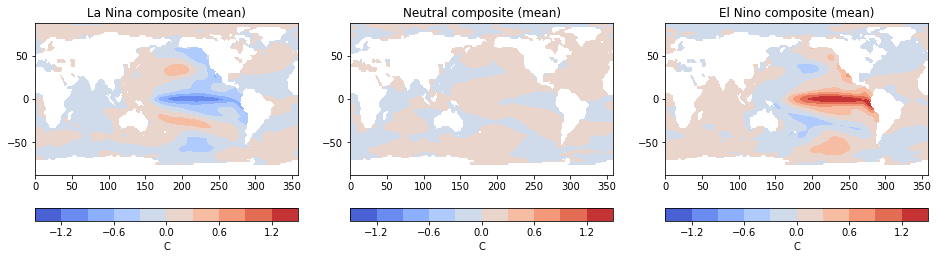

In [ ]:
#No need to understand the code below !

# Compute the Nino 3.4 index
dfn34=dfa.sel(lon=slice(-170%360,-120%360),lat=slice(-5,5)).mean("lon").mean("lat")

# Identify timesteps where conditions are met
inino=dfn34.data>0.5# array of booleans (True or False)
inina=dfn34.data<-0.5
ineutral=((dfn34.data>-0.5) & (dfn34.data<0.5))

# Make data subsets selecting only relevant timesteps
dfnino=dfa.isel(time=inino)# keep only nino values
dfnina=dfa.isel(time=inina)
dfneutral=dfa.isel(time=ineutral)

# Compute composite mean 
dfnino=dfnino.mean("time")# average over time
dfnina=dfnina.mean("time")
dfneutral=dfneutral.mean("time")


# Plot that compares 
fig=plt.figure(None,figsize=(16,4))
plt.subplot(1,3,1)
plt.contourf(dfa.lon,dfa.lat,dfnina,levels=np.linspace(-1.5,1.5,11),cmap='coolwarm')
plt.colorbar(orientation='horizontal',label='C')
plt.title('La Nina composite (mean)')
plt.subplot(1,3,2)
plt.contourf(dfa.lon,dfa.lat,dfneutral,levels=np.linspace(-1.5,1.5,11),cmap='coolwarm')
plt.colorbar(orientation='horizontal',label='C')
plt.title('Neutral composite (mean)')
plt.subplot(1,3,3)
plt.contourf(dfa.lon,dfa.lat,dfnino,levels=np.linspace(-1.5,1.5,11),cmap='coolwarm')
plt.colorbar(orientation='horizontal',label='C')
plt.title('El Nino composite (mean)')

del dfnino,dfnina,dfneutral

<b>Step 4</b>: Look at the index covariance.

To see how the index Nino 3.4 SST relates to the spatial structure of El Nino and La Nina, we can compute covariance maps. The covariance map is the covariance between SST at a given lon,lat and the index.

As shown below, the covariance is positive with the eastern Pacific, negative in the western Pacific and slightly north and south. This means when there is an El Nino (positive index), the eastern Pacific warms and the western Pacific cools. When there is a La Nina (negative index), the eastern Pacific cools and the western Pacific warms. These are statistical relationships, meaning they happen often but not all the time.

Text(0.5, 1.0, 'covariance between SSTA and Nino 3.4 SSTA')

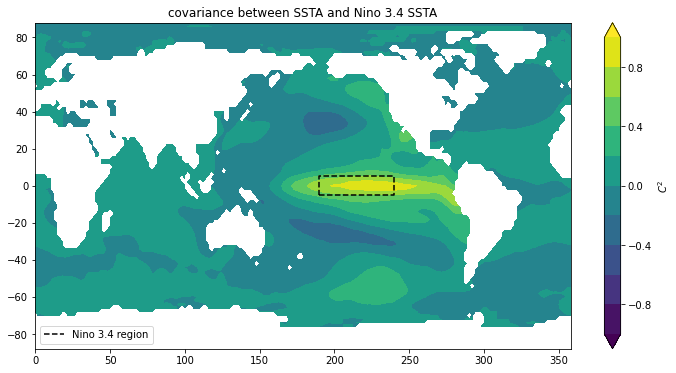

In [ ]:
#@title


dfn34=dfa.sel(lon=slice(-170%360,-120%360),lat=slice(-5,5)).mean("lon").mean("lat")# compute Nino 3.4 index

# compute the correlation map between the indice and anomalies
dfcorr=xr.cov(dfa,dfn34,dim='time')# this is a x-y map of covariance coefficients

fig=plt.figure(None,figsize=(12,6))
plt.contourf(df.lon,df.lat,dfcorr,levels=np.linspace(-1,1,11),extend='both')
plt.plot([-170%360,-120%360,-120%360,-170%360,-170%360],[-5,-5,5,5,-5],'k--',label='Nino 3.4 region')# draw the region box
plt.legend(loc=3)
plt.colorbar(label='$C^{2}$')
plt.title('covariance between SSTA and Nino 3.4 SSTA')


<b>Step 5</b>: A note on ENSO diversity (<b>optional</b>)

Although we have used a single index to classify ENSO events, each event tends to be different in terms of amplitude, timing and structure. To show this, we consider below SSTA in the Pacific (120E-80W) and near the equator (5N-5S) which we average on latitude to obtain a new data $T^{A}(x,t)$ that only depends on longitude and time. We see that there are strong El Nino events that peak in the eastern Pacific (called EP El Ninos), but also weaker events that peak in the central Pacific (called CP El Ninos). This is called ENSO diversity meaning there is more than one type of El Nino.

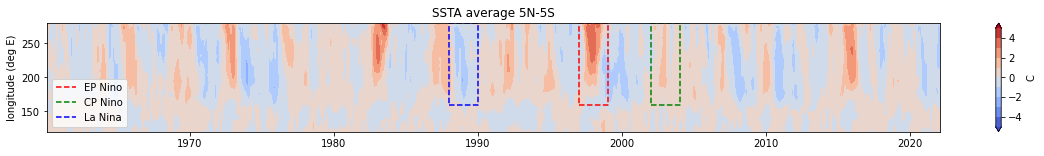

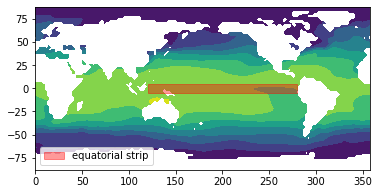

In [ ]:
#@title

# no need to understand the code below

# compute SST averaged in the equatorial band
dfaeq=dfa.sel(lon=slice(120%360,-80%360),lat=slice(-5,5)).mean("lat")

# compute SST anomalies+mean
dfam=dfa+df.mean("time")
dfameq=dfam.sel(lon=slice(120%360,-80%360),lat=slice(-5,5)).mean("lat")


# plot a hovmoller for SSTA
fig=plt.figure(None,figsize=(20,2))
fig.tight_layout()
plt.contourf(dfaeq.time_in_years.data,dfaeq.lon.data,dfaeq.data.T,cmap='coolwarm',levels=np.linspace(-5,5,11),extend='both')
plt.colorbar(label='C',orientation='vertical')
plt.title('SSTA average 5N-5S')
plt.ylabel('longitude (deg E)')
plt.ylim([120,280])
for ic,styl,lab in zip([1998,2003,1989],['r--','g--','b--'],['EP Nino','CP Nino','La Nina']):
  plt.plot([ic-1,ic+1,ic+1,ic-1,ic-1],[160,160,280,280,160],styl,label=lab)
plt.legend(loc=3)

# # plot a hovmoller for SSTAM
# fig=plt.figure(None,figsize=(20,2))
# fig.tight_layout()
# plt.contourf(dfameq.time_in_years.data,dfameq.lon.data,dfameq.data.T,levels=np.linspace(22,31,11),extend='both')
# plt.colorbar(label='C',orientation='vertical')
# plt.title('SSTAM average 5N-5S')
# plt.ylabel('longitude (deg E)')
# plt.ylim([120,280])
# for ic,styl,lab in zip([1998,2003,1989],['r--','g--','b--'],['EP Nino','CP Nino','La Nina']):
#   plt.plot([ic-1,ic+1,ic+1,ic-1,ic-1],[160,160,280,280,160],styl,label=lab)

fig=plt.figure(None,figsize=(6,3))
plt.contourf(df.lon,df.lat,df[0,:,:])
plt.fill_between([120,-80%360],[-5,-5],[5,5],color='red',alpha=0.4,label='equatorial strip')
plt.legend(loc=3)

del dfaeq,dfam,dfameq

<b>Step 6</b>: A note on ENSO seasonal synchronization (<b>optional</b>).

Another important is that El Nino and La Nina events tend to happen around the end of the year (December). This is called "seasonal synchronization". We show this below by plotting the Nino 3.4 SST index for some events but centered on December. The El Nino peak happens around that time (relative time=0), then a La Nina happens around December of the next year (relative time=1). 

The name "El Nino" actually comes from peruvian fisherman that would see a drop in fishes around december due to the warming. They nicknamed the phenomena "El Nino" which means "the boy" in spanish in reference to the birth of Jesus. The name "La Nina" was coined later by scientists as "the girl" just because it is the opposite. This means El Nino got its name from seasonal synchronization.



(-2.0, 2.0)

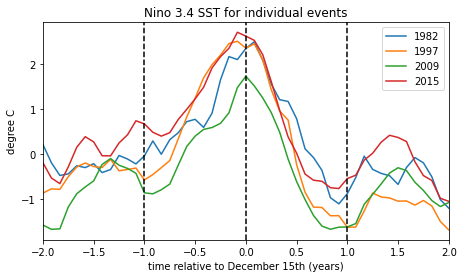

In [ ]:
#@title

# no need to understand the code below!

# plot some El Nino events with time relative to January (2 year window)
# (the code below is a bit too complex)
fig=plt.figure(None,figsize=(16,4))
fig.tight_layout()
plt.subplot(1,2,1)
for year in [1982,1997,2009,2015]:
  dfs=dfn34.sel(time=slice(str(year-2)+'-01-15',str(year+2)+'-12-15'))
  dfcenter=dfn34.sel(time=str(year)+'-12-15',method='nearest')
  plt.plot(dfs.time_in_years-dfcenter.time_in_years,dfs.data,label=str(year))# I am using the time_in_years axis because it is easier to add more lines
plt.legend()
for ix in [-1,0,1]:
  plt.axvline(x=ix,linestyle='--',color='black')
plt.title('Nino 3.4 SST for individual events')
plt.ylabel('degree C')
plt.xlabel('time relative to December 15th (years)')
plt.xlim([-2,2])



<b>Step 7</b>: Summary

In the section we have analyzed the ENSO with standard metrics. The Nino 3.4 SST index is used to classify conditions into El Nino, La Nina or neutral conditions, which is important for monitoring and forecasting. You can compute covariance maps to look at how SST varies with the index (or optionally composites). We have also seen that each event is unique (called ENSO diversity) and that they tend to peak in December (called seasonal synchronization). Below we repeat the main steps.

In [ ]:
#@title


# compute Nino 3.4 SST index
dfn34=dfa.sel(lon=slice(-170%360,-120%360),lat=slice(-5,5)).mean("lon").mean("lat")

# look at index covariance maps
dfcov=xr.cov(dfa,dfn34,dim='time')# this is a x-y map of covariances

del dfa, dfn34, dfnino, dfnina, dfcov# erase from memory

<b>Exercises </b>:
- There are other SST indices than Nino 3.4 SST. Write a code to compute and plot the indices Nino 4 SST and Nino 3 SST using the definitions found [here](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni). Why do we use SST indices in different regions and not just one? discuss briefly  
- The current ENSO conditions and forecasts are provided rountinely by different institutions. Go check the current ENSO conditions and forecasts from [here](https://www.cpc.ncep.noaa.gov/products/analysis_monitoring/enso_advisory/ensodisc.shtml). Discuss briefly the current conditions in terms of the maps of SSTA anomalies and the Nino SST indices. What should we expect 6 month from now according to the forecasts?  

In [ ]:
# Write you code here

Write your answers here

# Perform PCA (1D data)

Lets now do a Principal Component Analysis (PCA) on our data. This method has already been introduced in the class (maybe as a different name, it has many in the litterature). Here we will review the theory briefly, then perform the PCA on a simpler case. 

<b>Step 1</b>: Prepare the data

Here we will perform PCA on a simpler case where the data has only one spatial dimension. For this we will consider the SSTA averaged 5N-5S in the Pacific (120E-80W) from earlier, which we will note $T^{A}(x,t)$ hereafter. We plot it below once again. 

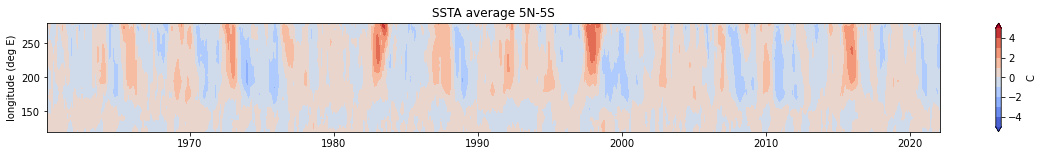

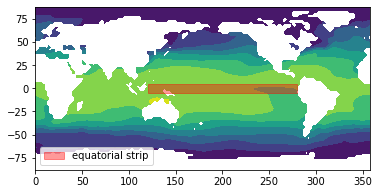

In [ ]:
#@title
#
# compute SST anomalies
dfa=getmyssta()

#compute SSTA averaged in the equatorial band
dfaeq=dfa.sel(lon=slice(120%360,-80%360),lat=slice(-5,5)).mean("lat")

# plot a hovmoller for SSTA
fig=plt.figure(None,figsize=(20,2))
fig.tight_layout()
plt.contourf(dfaeq.time_in_years.data,dfaeq.lon.data,dfaeq.data.T,cmap='coolwarm',levels=np.linspace(-5,5,11),extend='both')
plt.colorbar(label='C',orientation='vertical')
plt.title('SSTA average 5N-5S')
plt.ylabel('longitude (deg E)')
plt.ylim([120,280])


fig=plt.figure(None,figsize=(6,3))
plt.contourf(df.lon,df.lat,df[0,:,:])
plt.fill_between([120,-80%360],[-5,-5],[5,5],color='red',alpha=0.4,label='equatorial strip')
plt.legend(loc=3)


<b>Step 2</b>: brief review of Principal Component Analysis (PCA).

We provide below a brief review of PCA, a few notes:
- The notations here may be different from what you have seen in other parts of the course: there are many terminologies for PCA from one field to another which gets confusing. The notations here are also different from the rest of the notebook.
- We are interested here in climate data where each sample is a timestep, which is specific (PCA applies more generally to data samples, even without a time component).
- If you want another explanation, a very good and simple manual of PCA for climate data can also be found [here](https://github.com/sulianthual/TPN7-ENSOSST/blob/main/BjornssonVenegas2000.pdf) (no need to read it). 

Lets note our SST anomalies $T^{A}(x,t) $ data more generally as the matrix $\mathbf{X}=[\mathbf{x}_1\cdots \mathbf{x}_{n}]$ of size $p$ x $n$ ($p$ for spatial dimension, $n$ for time), where each column $\mathbf{x}_{k}$ is a sample of size $p$ (here a timestep). We note individual elements as $x_{ik}$ where each sample is a vertical array reading $\mathbf{x}_{k}=[x_{1k},...,x_{pk}]^{T}$.

The centered data with sample mean removed reads: 
$$\qquad\mathbf{X}'=[\mathbf{x}_1-\overline{\mathbf{x}}\cdots \mathbf{x}_{n}-\overline{\mathbf{x}}],$$ 
i.e. $x'_{ik}=x_{ik}-\overline{x}_{i}$ where $\overline{x}_{i}=(1/n)\sum_{k=1}^{n}x_{ik}$ denotes sample mean. (For our data, we have already removed the sample mean i.e. the temporal mean).

The Empirical Orthogonal Functions (EOFs) are deduced from the covariance matrix of the data, of size $p$ x $p$, which we note:
$$\qquad{\mathbf{C}} = \frac{1}{n}\mathbf{X}'(\mathbf{X}')^T.$$
that is symmetric and positive semi-definite. On the diagonal, the values of $\mathbf{C}$ are variances (between a spatial location and itself), while the values of $\mathbf{C}$ elsewhere are covariances (between a spatial location and a different one). For individual elements this reads $C_{ij}=(1/n)\sum_{k=1}^{n} x'_{ik}x'_{jk}$.


Solving for the EOFs consists in solving the eigenvalue problem:

$$\qquad{\mathbf{C}} = \mathbf{E} \mathbf{\Lambda}\mathbf{E}^{T}$$

where $\mathbf{\Lambda}$ is a diagonal matrix $p$ x $p$ containing the eigenvalues $\lambda_{j}$ of $\mathbf{C}$ on the diagonal, and $\mathbf{E}$ is a $p$ x $p$ matrix containing the eigenvectors as columns. The $\mathbf{e_{i}}$ column  vectors of $\mathbf{E}$ are the eigenvectors of $\mathbf{C}$ corresponding to the eigenvalues $\lambda_{j}$. Each eigenvector is called an Empirical Orthogonal Function. 

The EOFs are orthogonal to each other (more specifically, uncorrelated in space) and orthonormal, i.e. $\mathbf{e_{j}}.\mathbf{e_{l}}=\delta_{jl}$ where $\delta_{jl}=1$ if $j=l$ and zero otherwise. For individual elements this reads $\sum_{j=i}^{p}e_{ij}e_{jl}=\delta_{jl}$. This stems from $\mathbf{E}^T\mathbf{E}=\mathbf{E}\mathbf{E}^T=\mathbf{I}$ where $\mathbf{I}$ is the identify matrix. 

The Expansion Coefficient (EC) $\mathbf{a_{j}}$ of size $n$ is the projection of the data in $\mathbf{X}$ on the eigenvector $\mathbf{e_{j}}$, which we note:
$$\mathbf{a_{j}} = \mathbf{X} \mathbf{e_{j}}$$
We note individual elements as $a_{kj}=\sum_{i=1}^{p}x_{ik}e_{ij}$ where each $\mathbf{a_{j}}=[a_{1j},...,a_{nj}]$ is a horizontal array . The ECs are here timeseries (centered on zero). They relate to variance as $\mathbf{a_{j}}.\mathbf{a_{l}}=\lambda_{j}\delta_{il}$, where distinct ECs are uncorrelated between each other. 

The matrix $\mathbf{\Lambda}$ is a rotated version of the covariance matrix $\mathbf{C}$, also of size $n$ x $n$, with only variances $\lambda_{j}$ along its diagonal and zero elsewhere. Typically we sort $\lambda_{j}$ in decreasing order and we define explained variance as $\lambda_{j}/\text{trace}(\mathbf{\Lambda})$, usually expressed in %. Also  $\text{trace}(\mathbf{\Lambda})=\sum_{j=1}^{p} \lambda_{j}$. 

With this, we can reconstruct the original data as:

$$\mathbf{X'} = \sum_{j=1}^{P} \mathbf{R}_{j} \text{ with } \mathbf{R}_{j}=\mathbf{a}_{j}\mathbf{e_{j}}$$
where $P\le p$, and where $\mathbf{R}_{j}$ is the contribution from the j-th mode (i.e. the pair of PC $\mathbf{a}_{j}$ and EOF $\mathbf{e}_{j}$) to the reconstruction. For individual elements this reads $x'_{ik}=\sum_{j=1}^{n}a_{kj}e_{ij}$. Typically we want to truncate the reconstruction to a small $P$, which retains the first (i.e. dominant) modes that explain the most variance. This is useful for dimensionality reduction (from $p$ to $P$) as well for understanding through analysis of the first EOFs and ECs.


Hereafter for our problem we will use the looser notations with $EC_{j}$ the principal component $\mathbf{a_{j}}$ and $EOF_{j}$ to empirical orthogonal function $\mathbf{e_{j}}$. The original SSTA data is reconstructed as:

$T^{A}(x,t)=\sum_{j=1}^{P} R_{j}\text{ with } R_{j}=EC_{j}(t) EOF_{j}(x)$




<b>Step 3:</b> Compute the PCA 

Below we compute the PCA for the SSTA in the equatorial strip defined above. There are several python packages that can do this, here we will use the package sklearn.PCA. We keep only the first 5 components ($P=5$), as we can see that explained variance (sorted by decreasing values) rapidly decay. 

EOF0.EOF1= -1.9666913e-08
EOF0.EOF0= 1.0
-9.4115734e-05


(0.0, 100.0)

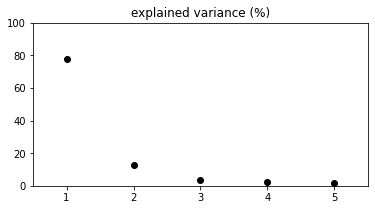

In [ ]:
#@title
# Apply PCA to the data using package sklearn.PCA

nmodes=5# this is how much modes we will keep (we could keep up to nx the spatial dimension)
pca = PCA(n_components=nmodes, random_state=1)# this creates a PCA object (still empty). We will only keep first n=5 EOFs
Xpca=pca.fit_transform(dfaeq.data)# this computes the PCA analysis from the data (it also modifies the pca object)
pcas=Xpca[:,:]# these are the ECs i.e. timeseries EC[t,n] as a numpy array (I note them pca which is confusing sorry)
exp_var = pca.explained_variance_ratio_# these are the explained variance (from 0 to 1) exp_var[n] as a numpy array. They are sorted by default.
eofs=pca.components_[:,:]# these are the EOFs EOF[n,x] as a numpy array
mode=np.linspace(1,nmodes,nmodes)# this is an axis for the modes (starting from 1) as a numpy array

# Check the EOFs orthogonality
print('EOF0.EOF1=',np.dot(eofs[0,:],eofs[1,:]))#=0

# Check the EOFs orthonormality
print('EOF0.EOF0=',np.dot(eofs[0,:],eofs[0,:]))#=1

# Check the ECs are uncorrelated
print(np.dot(pcas[:,1],pcas[:,0]))# =0

fig=plt.figure(None,figsize=(6,3))
plt.plot(mode, exp_var*100,'ko')# multiply by 100 to get explained variance in %
plt.title('explained variance (%)')
plt.xlim([0.5,5.5])
plt.ylim([0,100])

<b>Step 4:</b> Plot the first EOFS and ECs and their reconstruction of data

Below we show the first two EOFs and ECs. The EOFs show the spatial structure of the mode and the ECs their temporal evolution. 

The first EOF shows some pattern in the east part of the Pacific and its EC looks like the index Nino 3.4 SST: it is very likely representative of the ENSO. The second EOF is less obvious, all we can say is that it correspond to warming/cooling that is opposite between the central and eastern Pacific. 

Because the EOFs are orthogonal and the ECs are uncorrelated, we tend to associate each EOF to a different phenomena or "mode of variability". For example here, we can roughly say that the ENSO mode projects its covariance on EOF1, or that it "is" EOF1. This is not entirely true (a phenomena can sometimes project on several EOFs) but it is a good approximation.
 


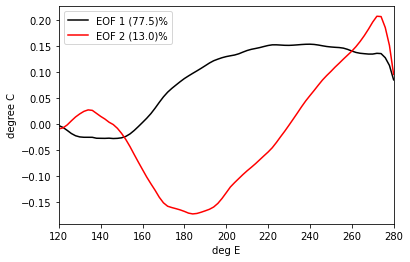

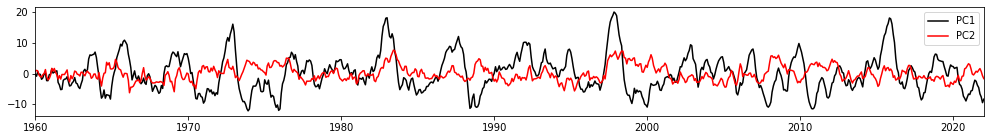

In [ ]:
#@title
# plot the EOFs and the ECs

# plot EOF1 and EOF2 (the spatial structures)
fig=plt.figure(None,figsize=(6,4))
plt.plot(dfaeq.lon, eofs[0,:],'k-',label='EOF 1 ('+str(np.round(exp_var[0]*100,1))+')%')
plt.plot(dfaeq.lon, eofs[1,:],'r-',label='EOF 2 ('+str(np.round(exp_var[1]*100,1))+')%')
plt.legend()
plt.margins(x=0)
plt.xlabel('deg E')
plt.ylabel('degree C')

# Plot PC1 and PC2 (the timeseries)
fig=plt.figure(None,figsize=(17,2))
plt.plot(dfaeq.time,pcas[:,0],'k-',label='PC1')
plt.plot(dfaeq.time,pcas[:,1],'r-',label='PC2')
plt.legend()
plt.margins(x=0)



Below we plot EC1 against EC2. We can see that the data aligns on the EC1 axis (horizontal), meaning it varies along this axis. This is because EOF1 explains most of the variance (77.5%). Meanwhile, there is little variations along the EC2 axis (vertical) because it explains less variance in comparison (only 13%). 

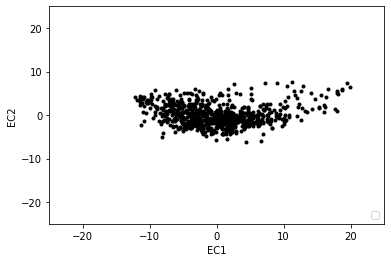

In [ ]:
# Plot EC1 vs EC2 as a scatterplot
fig=plt.figure(None,figsize=(6,4))
plt.plot(pcas[:,0],pcas[:,1],'k.',label='_nolegend_')
plt.xlim([-25,25])
plt.ylim([-25,25])
plt.xlabel('EC1')
plt.ylabel('EC2')
plt.legend(loc=4)


<b>Step 5</b>: Analyze the reconstruction of data

Comparing each reconstruction $R_{j}(x,t)=EC_{j}(t) EOF_{j}(x)$ to the initial data $T^{A}$ is also useful. A good way to do this is start from a full reconstruction and progressively degrade to see what remains, as shown below. If we keep R1 to R5 , the reconstruction is very similar to initial data. If we keep only R1+R2 , it is also extremely close (we loose small details with little variance). If we keeping only R1 we have lost important details, but we still have the ENSO. 

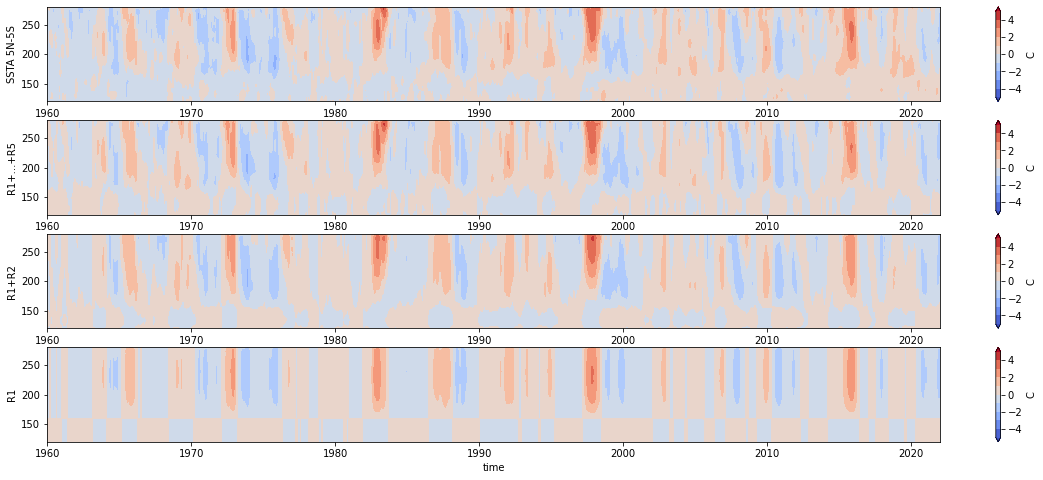

In [ ]:
#@title
dfa=df.groupby('time.month')-df.groupby("time.month").mean("time")
dfaeq=dfa.sel(lon=slice(120%360,-80%360),lat=slice(-5,5)).mean("lat")

# plot a hovmoller for SSTA
fig=plt.figure(None,figsize=(20,8))
fig.tight_layout()

nrow,ncol,isub=4,1,1

plt.subplot(nrow,ncol,isub)
isub+=1
plt.contourf(dfaeq.time.data,dfaeq.lon.data,dfaeq.data.T,cmap='coolwarm',levels=np.linspace(-5,5,11),extend='both')
plt.colorbar(label='C',orientation='vertical')
plt.ylabel('SSTA 5N-5S')
plt.ylim([120,280])

plt.subplot(nrow,ncol,isub)
isub+=1
R15=np.sum([ np.outer(eofs[i,:],pcas[:,i]) for i in range(5)],axis=0)# sum of R1 to R5
plt.contourf(dfaeq.time.data,dfaeq.lon.data,R15,cmap='coolwarm',levels=np.linspace(-5,5,11),extend='both')
plt.colorbar(label='C',orientation='vertical')
plt.ylabel('R1+...+R5')
plt.ylim([120,280])

plt.subplot(nrow,ncol,isub)
isub+=1
R12=np.sum([ np.outer(eofs[i,:],pcas[:,i]) for i in range(2)],axis=0)# sum of R1 to R2
plt.contourf(dfaeq.time.data,dfaeq.lon.data,R12,cmap='coolwarm',levels=np.linspace(-5,5,11),extend='both')
plt.colorbar(label='C',orientation='vertical')
plt.ylabel('R1+R2')
plt.ylim([120,280])
         
plt.subplot(nrow,ncol,isub)
isub+=1
R1=np.outer(eofs[0,:],pcas[:,0])
plt.contourf(dfaeq.time.data,dfaeq.lon.data,R1,cmap='coolwarm',levels=np.linspace(-5,5,11),extend='both')
plt.colorbar(label='C',orientation='vertical')
plt.ylabel('R1')
plt.xlabel('time')
plt.ylim([120,280])

del R1,R12,R15

<b>Step 6:</b> Choose the sign of the EOFs and ECs 

We can arbitrary change the sign of the EOFs and ECs to make our data more readable. For example, if we define $EOF_{i}'=-EOF_{i}$, $EC_{i}'=-EC_{i}$, we keep the same reconstruction $R_{i}=EC_{i}'(t) EOF_{i}'(x)$. The EOFs also conserve their properties of orthonormality and orthogonality, while the ECs remains uncorrelated between each other. In fact, the sign of a EC is arbitrary and is determined at random by the code (you could find different signs for two very similar datasets). Below we have changed the sign of EOF2 and EC2 as an example.

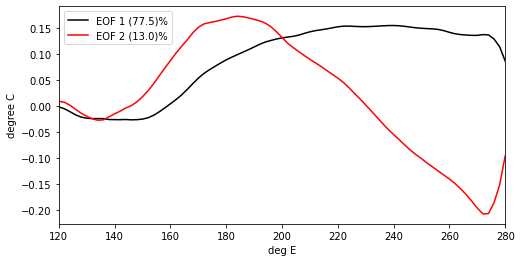

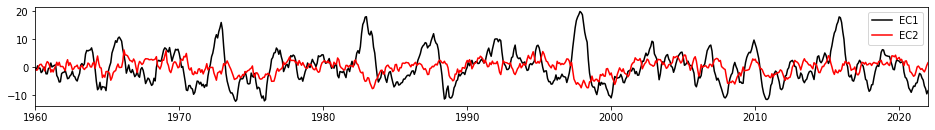

In [ ]:
#@title

# Change the sign of the ECs and EOFs

# This function changes the sign of EOFi and ECi (specify i>=1)
def changepcasign(eofs,pcas,i):
  try: 
    eofs[i-1,:]=-eofs[i-1,:]
    pcas[:,i-1]=-pcas[:,i-1]
  except:
    print('didnt work, some error somewhere')
  return eofs,pcas

eofs,pcas=changepcasign(eofs,pcas,2)# change mode i=2

# plot EOF1 and EOF2 (the spatial structures)
fig=plt.figure(None,figsize=(8,4))
plt.plot(dfaeq.lon, eofs[0,:],'k-',label='EOF 1 ('+str(np.round(exp_var[0]*100,1))+')%')
plt.plot(dfaeq.lon, eofs[1,:],'r-',label='EOF 2 ('+str(np.round(exp_var[1]*100,1))+')%')
plt.legend()
plt.margins(x=0)
plt.xlabel('deg E')
plt.ylabel('degree C')


# Plot EC1 and EC2 (the timeseries) vs Nino 3.4 SST
fig=plt.figure(None,figsize=(16,4))
plt.subplot(2,1,1)
plt.plot(dfaeq.time,pcas[:,0],'k-',label='EC1')
plt.plot(dfaeq.time,pcas[:,1],'r-',label='EC2')
plt.legend()
plt.margins(x=0)

<b>Step 7</b>: Summary

In this section we have provided a quick review on the theory of Principal Component Analysis (which you should understand well). We have applied it to a simple example (SSTA with one spatial dimension) with the python package sklearn.PCA. 

Each EOF-EC is approximately a different "mode of variability". The data is aligned along the ECs axis with most explained variance. The data reconstruction is improved with more EOFs but not too much with EOFs that explain little variance. Finally, you can change the sign of the EOFs and ECs because it is arbitrary.


In [ ]:
# Compute the Principal Component Analysis

# get the input data (centered on zero)
dfa=getmyssta()
dfaeq=dfa.sel(lon=slice(120%360,-80%360),lat=slice(-5,5)).mean("lat")

# Compute the PCA analysis (with package sklearn.PCA)
nmodes=5# this is how much modes we will keep (we could keep up to nx the spatial dimension)
pca = PCA(n_components=nmodes, random_state=1)# this creates a PCA object (still empty). We will only keep first n=5 EOFs
Xpca=pca.fit_transform(dfaeq.data)# this computes the PCA analysis from the data (it also modifies the pca object)
pcas=Xpca[:,:]# these are the ECs or timeseries EC[t,n] as a numpy array
exp_var = pca.explained_variance_ratio_# these are the explained variance (from 0 to 1) exp_var[n] as a numpy array. They are sorted by default.
eofs=pca.components_[:,:]# these are the EOFs EOF[n,x] as a numpy array
mode=np.linspace(1,nmodes,nmodes)# this is an axis for the modes (starting from 1) as a numpy array

# Reconstruct data with one mode Ri
imod=0# index of the mode from 0
Ri=np.outer(eofs[imod,:],pcas[:,imod])

# Optional: change the sign of the PCs and EOFs
eofs,pcas=changepcasign(eofs,pcas,2)# change mode i=2

del pcas,eofs,Ri

<b>Exercises</b>: There are no exercises for this section. 

# Perform PCA (2D data)

Now that we have understood a bit better the fundamentals of the PCA, we apply it to our SST fields $T(x,y,t)$ that depends on both longitude $x$, latitude $y$ and time $t$. The present case is slightly harder than the one above because there is more than one spatial dimension, and there are badvalues. You don't really need to understand all the steps here (it gets a bit too technical). 

<b>Step 1:</b> Prepare the data.

We have to deal with the two issues mentionned above when preparing the data. First, PCA accepts a single spatial dimension, so we will have to "stack" the longitude and latitude dimensions into a single dimension which we will call $z$. For our discrete array $T(x,y,t)=T_{i,j,k}$, the stacked array reads $T_{m,k}$ with new axis given by $m=i+jN_{y}$  and $0\le m \le N_{x}N_{y}-1$. You can always unstack to retrieve the original shape. 

In [ ]:
#@title
df=getmysst()
dfa=getmyssta()

# stack using numpy 
nx=len(dfa.lon.data)
ny=len(dfa.lat.data)
nt=len(dfa.time.data)
print(nx,ny,nt)
data=dfa.data# get the numpy array (3D)
print('1: ', data.shape)
data=np.reshape(data,(nt,ny*nx))# stack spatial dimensions
print('2: ', data.shape)


180 89 745
1:  (745, 89, 180)
2:  (745, 16020)


Second, the sklearn package we use for PCA doesn't accept badvalues, so we will have to remove them manually from the data. What we do is simply exclude any spatial location with badvalues from the input data. We also keep track of the locations of good and badvalues as it will be useful when reconstructing the data. 

Note: an easier (but less rigorous) method is simply to put all badvalues to zero (as they will not contribute to covariance) and keep all the original data locations. We wont review this method here. 

In [ ]:
isdatagood=~np.isnan(data).any(axis=0)# save an array telling if data is good (True) or bad(False) at each spatial location
print('1: ', isdatagood)
print('2: ', data.shape)
data=data[:,isdatagood]# keep only spatial points without NaN values
print('3: ', data.shape)# we went from 16020 spatial locations to 10988


1:  [False False False ...  True  True  True]
2:  (745, 16020)
3:  (745, 10988)


<b>Step 2</b>: Compute the PCA

Here we compute the EOFs and ECs in the same way as before. We get a few modes with variance 20 to 5%.

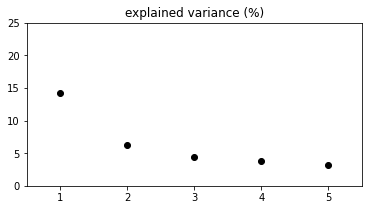

In [ ]:
#@title
# Applying PCA is still the same

nmodes=5# this is how much modes we will keep (we could keep up to nx the spatial dimension)
pca = PCA(n_components=nmodes, random_state=1)# this creates a PCA object (still empty). We will only keep first n=5 EOFs
Xpca=pca.fit_transform(data)# this computes the PCA analysis from the data (it also modifies the pca object)
pcas=Xpca[:,:]# these are the ECs or timeseries EC[t,n] as a numpy array
exp_var = pca.explained_variance_ratio_# these are the explained variance (from 0 to 1) exp_var[n] as a numpy array
eofs=pca.components_[:,:]# these are the EOFs EOF[n,x] as a numpy array
mode=np.linspace(1,nmodes,nmodes)# this is an axis for the modes (starting from 1) as a numpy array

fig=plt.figure(None,figsize=(6,3))
plt.plot(mode, exp_var*100,'ko')# multiply by 100 to get explained variance in %
plt.title('explained variance (%)')
plt.xlim([0.5,5.5])
plt.ylim([0,25])

del data

<b>Step 4:</b> Get the EOF maps

The EOFs we get are on the stacked dimension "z" and they dont include the badvalues (continents). To get the EOF maps we can visualize, we fill empty maps with the good values then unstack the z dimension into longitude and latitude.

In [ ]:
# Create an EOF array with the desired shapes an badvalues
eofsnew=np.empty((nmodes,ny*nx))+np.nan# an empty map with badvalue everywhere
for i in range(nmodes):
  eofsnew[i,isdatagood]=eofs[i,:]# fill where there are "good" values
eofs=eofsnew

# Unstack the z dimension
eofs=np.reshape(eofsnew,(nmodes,ny,nx))

del eofsnew

<b>Step 5:</b> Analyse the EOFs and ECs. 

Below we plot the first EOFs and ECs (after optionally rescaling them). The first EOF (15%) is the ENSO. The next EOFs are a mix other modes of variability in the northern Pacific (and a bit of the ENSO variability as we can see they still have some of the warming/cooling pattern). We will not discuss their interpretation too much here (it gets complicated). 

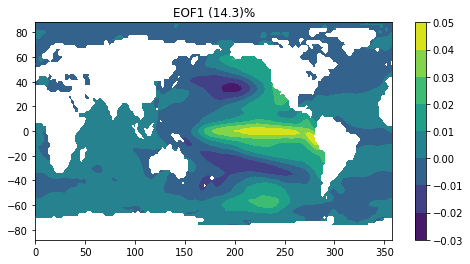

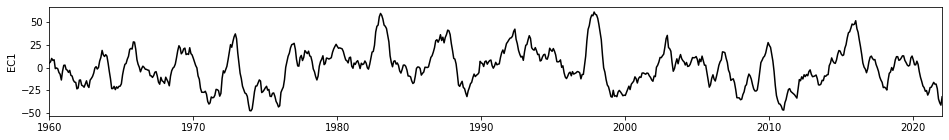

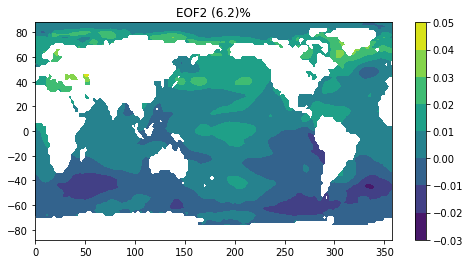

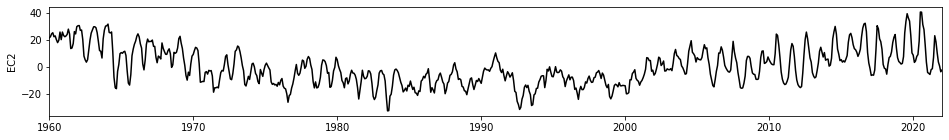

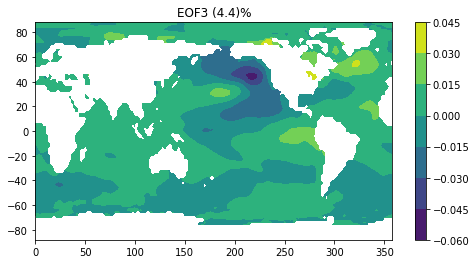

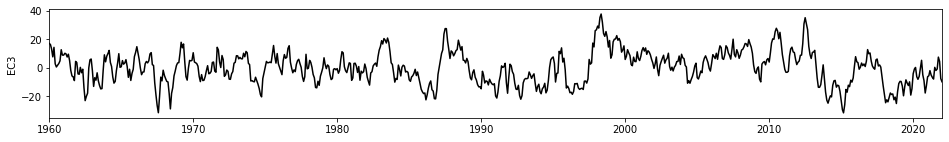

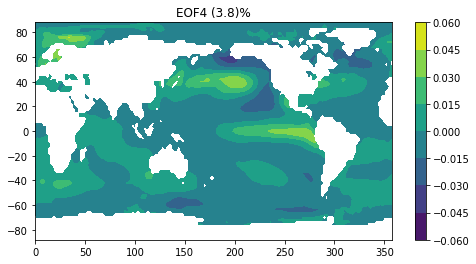

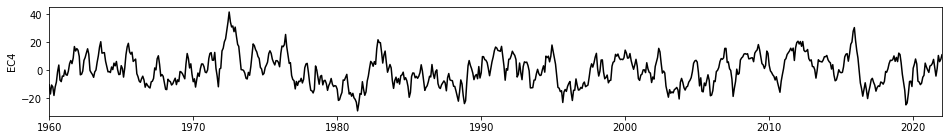

In [ ]:
#@title

# Change the sign of the ECs and EOFs
modsign=[1,1,1,1,1]# the desired sign changes (must be of size nmodes)
for i in range(nmodes):
  eofs[i,:,:]=modsign[i]*eofs[i,:,:]
  pcas[:,i]=modsign[i]*pcas[:,i]


# plot EOF and EC for each mode
for imod in range(4):
  #
  fig=plt.figure(None,figsize=(8,4))
  plt.contourf(dfa.lon,dfa.lat, eofs[imod,:,:])
  plt.colorbar()
  plt.title('EOF'+str(imod+1)+' ('+str(np.round(exp_var[imod]*100,1))+')%')
  # 
  fig=plt.figure(None,figsize=(16,2))
  plt.plot(dfa.time,pcas[:,imod],'k-',label='EC1')
  plt.margins(x=0)
  plt.ylabel('EC'+str(imod+1))

<b> Step 6 </b>: Summary

In this section we have computed the PCA of SSTA over the entire Earth. There are two additional challenges in dealing with the data: 1) several spatial dimensions that we stack into one and 2) badvalues (the continents) and that we need to exclude from the data prior to the PCA. After the PCA, we need to reconstruct the EOFs on the starting longitude-latitude grid. 

You don't really need to remember how we do all this because it is very technical. Below we write a function "getpca2d" that does all this and a function "plotpca2d" that plots EOF and EC for a given mode, you can reuse them. 

When computing the PCA we see that the ENSO appears as the first EOF with around 15% explained variance. It is thus the leading mode of SST variability in our data (after separating the seasonal cycle and trend). 



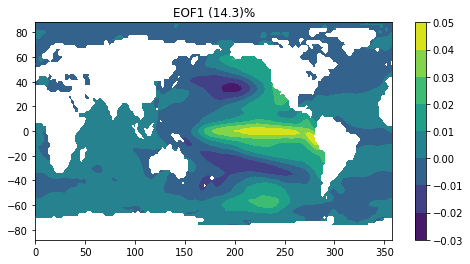

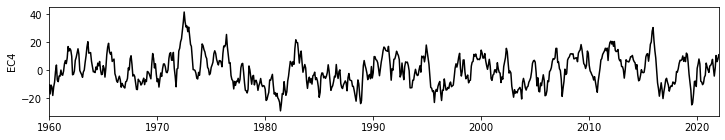

In [ ]:
# A function to perform PCA for 2D data
# input: dfa (DataArray), must be of shape=time,lon,lat and can have NaN values
# output: eofs, pcas, exp_var as numpy arrays
# options: 
# nmodes: specifiy the number of modes to keep
# signchange=[]: sign changes to make. E.g signchange=[2,3] will change sign of EOF2,EOF3
def getpca2d(dfa,nmodes=5,signchanges=[]):

  # get the numpy array (dfa must be of shape=time,lon,lat)
  data=dfa.data

  # stack using numpy 
  nx=len(dfa.lon.data)
  ny=len(dfa.lat.data)
  nt=len(dfa.time.data)
  data=np.reshape(data,(nt,ny*nx))# stack spatial dimensions

  # keep only good values for PCA
  isdatagood=~np.isnan(data).any(axis=0)# save an array telling if data is good (True) or bad(False) at each spatial location
  data=data[:,isdatagood]# keep only spatial points without NaN values

  # nmodes=5# this is how much modes we will keep (we could keep up to nx the spatial dimension)
  pca = PCA(n_components=nmodes, random_state=1)# this creates a PCA object (still empty). We will only keep first n=5 EOFs
  Xpca=pca.fit_transform(data)# this computes the PCA analysis from the data (it also modifies the pca object)
  pcas=Xpca[:,:]# these are the ECs or timeseries EC[t,n] as a numpy array
  exp_var = pca.explained_variance_ratio_# these are the explained variance (from 0 to 1) exp_var[n] as a numpy array
  eofs=pca.components_[:,:]# these are the EOFs EOF[n,x] as a numpy array
  mode=np.linspace(1,nmodes,nmodes)# this is an axis for the modes (starting from 1) as a numpy array

  # Change the sign of the PCs and EOFs (optional)
  for i in signchanges:
    eofs,pcas=changepcasign(eofs,pcas,i)# change mode i=2

  # Create an EOF array with the desired shapes an badvalues
  eofsnew=np.empty((nmodes,ny*nx))+np.nan# an empty map with badvalue everywhere
  for i in range(nmodes):
    eofsnew[i,isdatagood]=eofs[i,:]# fill where there are "good" values
  eofs=eofsnew

  # Unstack the z dimension
  eofs=np.reshape(eofsnew,(nmodes,ny,nx))

  return eofs,pcas,exp_var

# Plot EOFi and PCi for the mode i (specifiy i>=1)
def ploteof2d(i,eofs,exp_var,dfa):
  imod=i-1# index of the mode
  fig=plt.figure(None,figsize=(8,4))
  plt.contourf(dfa.lon.data,dfa.lat.data, eofs[imod,:,:])
  plt.colorbar()
  plt.title('EOF'+str(imod+1)+' ('+str(np.round(exp_var[imod]*100,1))+')%')

def plotpc(i,pcas,dfa):
  fig=plt.figure(None,figsize=(12,2))
  plt.plot(dfa.time.data,pcas[:,imod],'k-',label='PC1')
  plt.margins(x=0)
  plt.ylabel('EC'+str(imod+1))

# Do the full analysis
dfa=getmyssta()
eofs,pcas,exp_var=getpca2d(dfa)
ploteof2d(1,eofs,exp_var,dfa)# plot EOF1 quickly
plotpc(1,pcas,dfa)# plot EC1 quickly



<b>Exercises</b>:
- Recompute and plot the PCA without detrending the data. What happens? Why did we separate the trend $T^{D}$ from the data in the first place?
- Due to our representation of data on a regular longitude-latitude grid (called [Mercator projection](https://en.wikipedia.org/wiki/Mercator_projection)), grid cells are wider at the equator than the poles. Discuss quickly how you think the above Mercator projection may affect PCA, and how we could remedy to it in theory.   
- Below we show a map of SSTA variance. Variance is maximal on western borders where there are strong currents that generate eddies (e.g. the [Gulf stream](https://en.wikipedia.org/wiki/Gulf_Stream)). These variations are strong but very localized and they do not correlate much with the rest of the planet. Discuss quickly why you think this signal is not the main signal captured by EOFs. 




Text(0.5, 1.0, 'SST VARIANCE')

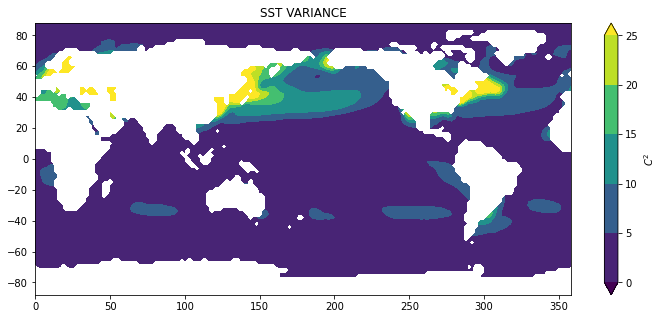

In [ ]:
 # compute the variance
fig=plt.figure(None, figsize = (12, 5))
plt.contourf(df.lon,dfa.lat,df.var("time").data,levels=np.linspace(0,25,6),extend='both')
plt.colorbar(label='$C^{2}$')
plt.title('SST VARIANCE')

In [ ]:
# write your code here

Write your answers here!

# Take-Home Exercise

The IPCC (GIEC in french) produces a report every 6 to 7 years that assesses the impacts of climate change. Do the following:
- Go to the IPCC report website [here](https://www.ipcc.ch/report/ar6/wg1/).
- Download the Annex IV, Modes of Variability (one of the authors is Christophe Cassou from CERFACS in Toulouse).
- Open the pdf and look at Figure AIV.3 (repeated below): it provides a summary of the ENSO in term of spatial pattern and temporal evolution. You can note the use of the Nino 3.4. SST index and EOF1, but also other fields and metrics (winds, precipitations,etc).
- Look at the other figures (AIV.1 to 10) that summarize other major climate modes: IOB, IOD, AZM, AMM, etc 



In [ ]:
#@title
Image(url="https://raw.githubusercontent.com/sulianthual/TPN7-ENSOSST/main/sketch_ENSOIPCC.png", width=600)

The goal of the exercise is to recompute some of the metrics and EOFs for the above climate modes and to compare the results to the ones of the IPCC report: 
- Choose one of the following climate modes: IOB, IOD, AZM, AMM
- Prepare the data accordingly (see below)
- compute and plot the SST index timeserie (panel b).
- compute the spatial pattern of SSTA from panel a (using covariance maps instead of regression maps). 
- compute and plot the first 3 EOFs of SSTA in the region indicated in panel a (or a rectangular region similar to it). 


Below we show the analysis for the ENSO mode that we have already covered:
- In the IPCC report they average the data over one season (e.g. DJF or MAM). To do this use the function seasonaverage below where you specificy the season you want.
- You can also reuse the other premade functions (getmysst, getmyssta, mytimetrend, getpca2d...). 


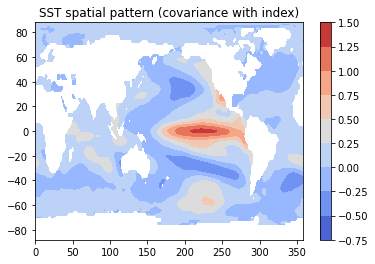

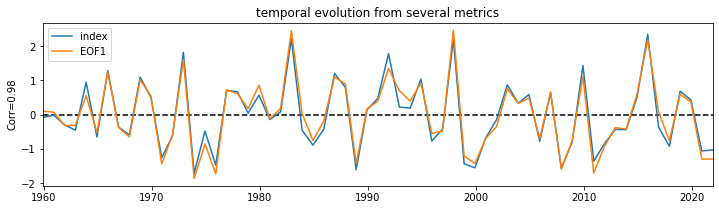

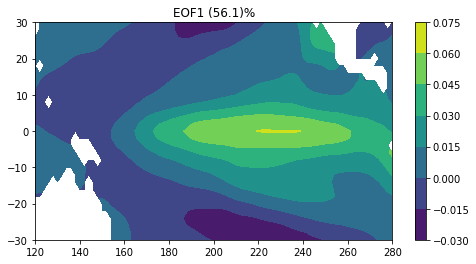

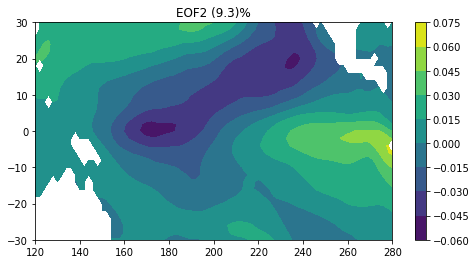

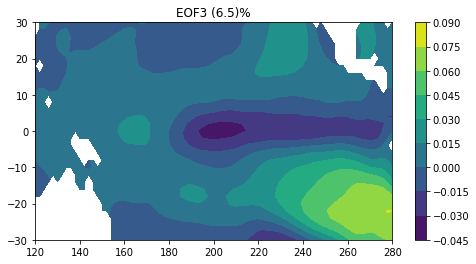

In [ ]:
# Select data averaged each year over one season
# E.g. df=seaspmaverage(df,"DJF"), then output is the data with DJF averages for each year
def seasonaverage(df,season):
  dfs=df.copy()# input data is dataarray df[time,lat,lon] monthly
  dfs=dfs.resample(time='QS-DEC').mean(dim="time")# convert data to seasonal average each year (DJF,MAM,JJA,SON)
  dfs=dfs.sel(time=dfs.time.dt.season==season)# keep only season of interest
  return dfs# output data is dfs[time,lat,lon] 
# dfa=seasonaverage(dfa,'DJF')# example

#############################################################

# Analysis for the ENSO mode
dfa=getmyssta()
dfa=seasonaverage(dfa,'DJF')

# Compute and plot EOF1
dfas=dfa.sel(lat=slice(-30,30),lon=slice(120,-80%360))
eofs,pcas,exp_var=getpca2d(dfas)

# Compute index 
index=dfa.sel(lon=slice(-170%360,-120%360),lat=slice(-5,5)).mean("lon").mean("lat")

#####

# Plot SST covariance map with index similar to panel a
fig=plt.figure(None,figsize=(6,4))
plt.contourf(dfa.lon,dfa.lat,xr.cov(dfa,index,dim='time'),cmap='coolwarm')
plt.colorbar()
plt.title('SST spatial pattern (covariance with index)')

# Plot index and PC1 (standardized) as in panel b
fig=plt.figure(None,figsize=(12,3))
plt.axhline(y=0,color='k',linestyle='--')
plt.plot(dfa.time,index/np.nanstd(index),label='index')
plt.plot(dfa.time,pcas[:,0]/np.nanstd(pcas[:,0]),label='EOF1')# standardized means divide by std
plt.legend(loc=2)
plt.margins(x=0)
plt.title('temporal evolution from several metrics')
plt.ylabel('Corr='+ str(np.round(np.corrcoef(index,pcas[:,0])[1][0],2)) )

# Plot 3 first EOFs
for i in [1,2,3]:
  ploteof2d(i,eofs,exp_var,dfas)


With the above, you have finished the notebook. If this wasn't enough here is some optional exercises:
- Plot regression maps instead of covariance maps.
- Plot the teleconnections patterns for precipitations (panel d in the figures of the IPCC report). We have started the procedure to prepare data below, but you will have to complete it on your own. 
- Find something else to do!

In [ ]:
  
# Procedure to prepare precipitation data (incomplete)
if False:
  # Download the dataset
  # source: https://psl.noaa.gov/data/gridded/data.gpcc.html
  !wget https://downloads.psl.noaa.gov/Datasets/gpcc/monitor/precip.monitor.mon.total.1x1.v2020.nc
  import os
  # we rename the file, otherwise xarray had some issues importing it (you can also do this manually)
  os.rename(r'precip.monitor.mon.total.1x1.v2020.nc', 'precip.mnmean.nc')
  
if False:
  dfp=xr.open_dataset('precip.mnmean.nc')# import netcdf data as a xarray dataset
  dfp=dfp['precip']# extract sst only as a dataarray object
  # print(df)# some optional checks

  # replace bad values (here very large values) with Nan
  dfp=dfp.where(dfp<10e30,other=np.nan)# does modify values <10e30, replaces other with nan

  # the rest is unfinished...


# To go further

<b> More reading</b>: 
- A very good online book on handling climate data can be found [here](https://earth-env-data-science.github.io/intro.html), it covers xarray and others tools in details.
- A very good manual on EOFs for climate data can be downloaded [here](https://github.com/sulianthual/TPN7-ENSOSST/blob/main/BjornssonVenegas2000.pdf).
- The online documentation for xarray can be found [here](https://docs.xarray.dev/en/stable/). 

<b> More tools</b>: 
- [ncdump](https://linux.die.net/man/1/ncdump) is unix program that can print a quick description of a netcdf file (ncdump -h myfile.nc), it needs to be installed an launched from a terminal.
- [ncview](http://meteora.ucsd.edu/~pierce/ncview_home_page.html) is a unix program that can visualize (even animate) a netcdf file at a glance, it needs to be installed an launched from a terminal.
- [netCDF4](https://www.earthinversion.com/utilities/reading-NetCDF4-data-in-python/) is another python package for handling netcdf data, but with less functionalities than xarray.


<b>More datasets:</b>

You could use some of the climate datasets below to make your own analysis. Some of them are too large but can you read their documentation to have an idea of what they contain. Look at the xarray tricks for importing multiple netcdf files [here](https://earth-env-data-science.github.io/lectures/xarray/xarray_tips_and_tricks.html).

Meta-lists:
- List of ocean datasets from Copernicus Marine Store [here](https://data.marine.copernicus.eu/products).
- List of atmosphere datasets from ECMWF [here](https://www.ecmwf.int/en/forecasts/datasets/browse-reanalysis-datasets).
- List of ocean and atmosphere datasets from NOAA [here](https://psl.noaa.gov/data/gridded/index.html).

Some specific datasets:

- [GPCC](https://psl.noaa.gov/data/gridded/data.gpcc.html) (precipitation reanalysis)
- [ERSLP](https://psl.noaa.gov/data/gridded/data.noaa.erslp.html) (sea level pressure reanalysis)
- [GODAS](https://www.psl.noaa.gov/data/gridded/data.godas.html) (ocean reanalysis, larger because multiple levels) 
- [ERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels-monthly-means?tab=overview) (atmosphere reanalysis, larger because multiple levels) 
- Mercator reanalysis [GREP](https://data.marine.copernicus.eu/product/GLOBAL_REANALYSIS_PHY_001_031/description) (ocean reanalysis at 1/4 resolution, very large)
- Mercator reanalysis [Glorys](https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/description\) (ocean reanalysis at 1/12 resolution, very very large).
- [CMIP6](https://esgf-node.ipsl.upmc.fr/projects/cmip6-ipsl/) multi-model ensemble of climate change simulations that form the basis for the IPCC report (waaay too large).

# Answers

Below all the answers to the exercises. Don't look or you will end up blind.

**Prepare the data**

*   at 1/4 resolution: 8x8x42x93=250 GB. At 1/12 resolution: 24x24x42x93=2.25TB 


Text(0.5, 1.0, 'Australia')

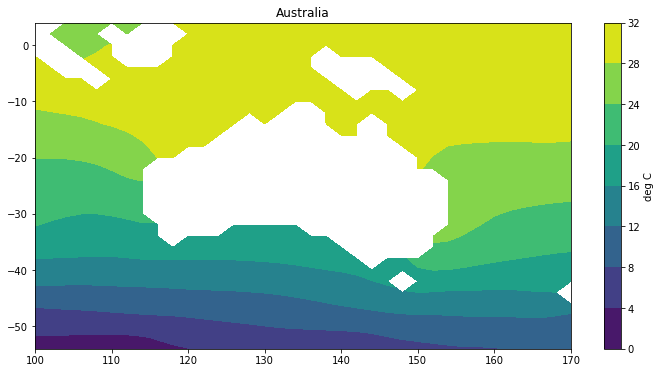

In [ ]:
# answer
df=getmysst()

df_subset=df.sel(lon=slice(100,170),lat=slice(-55,5)).isel(time=-0)

fig=plt.figure(None, figsize = (12, 6))
plt.contourf(df_subset.lon,df_subset.lat,df_subset.data)
plt.colorbar(label='deg C')
plt.title('Australia')

<b>Decompose the Signals</b>: 
- N=120 (12 month per years, 10 years of data)
- $k=12j+m$ 
- $T^{C}_{m}=\frac{1}{N_{Y}} \sum_{j=0}^{N_{Y}-1} T_{12j+m}$

<b>Analyze the ENSO</b>:
- We use several SST indices because of ENSO diversity: warming/cooling is not always in the same region.  
- Current conditions and forecasts depend on the time this notebook is executed, so no definitive answer.

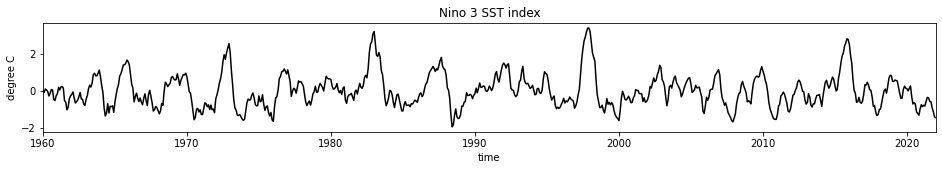

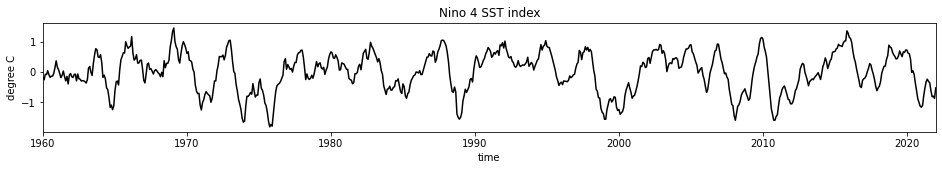

In [ ]:
# plot of Nino4 and Nino 3 SST
dfa=getmyssta()

dfn3=dfa.sel(lon=slice(-150%360,-90%360),lat=slice(-5,5)).mean("lon").mean("lat")
dfn4=dfa.sel(lon=slice(160%360,-150%360),lat=slice(-5,5)).mean("lon").mean("lat")

# plot 
fig=plt.figure(None,figsize=(16,2))
fig.tight_layout()
plt.plot(dfn3.time,dfn3.data,'k-')
plt.title('Nino 3 SST index')
plt.ylabel('degree C')
plt.xlabel('time')
plt.margins(x=0)

fig=plt.figure(None,figsize=(16,2))
fig.tight_layout()
plt.plot(dfn4.time,dfn4.data,'k-')
plt.title('Nino 4 SST index')
plt.ylabel('degree C')
plt.xlabel('time')
plt.margins(x=0)

<b>Perform PCA (2D data)</b>
- When keeping the trend it appears in the first EOF. Because it is an obvious signal we want to separate it such that the EOFs capture less obvious signals.
- With the Mercator projection, the grid cells are artifically wider at the poles, and thus their covariance will be artifically overestimated in the PCA. To remedy this, we could for example consider data on a more equally spaced grid (e.g. using interpolation), or account for cell size in the computation of the covariance matrix. 
- The western boundary currents and their eddies are a very localized phenomena. Even if they show a lot of variance, it is on a very small area and it does not covary much with the rest of the world. In comparison, ENSO is a phenomena where SSTs change altogether over a very wide area, thus with more covariance overall.




<b>Take-Home Exercise</b>: 

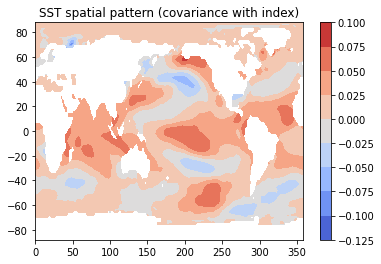

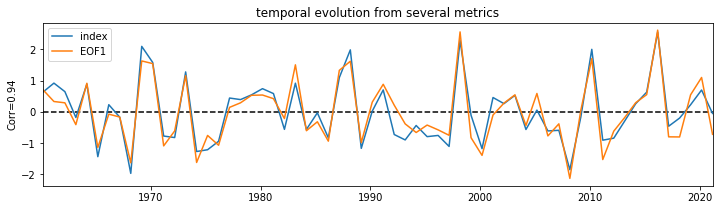

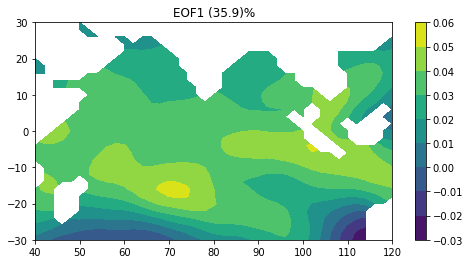

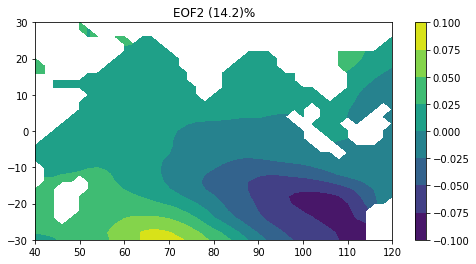

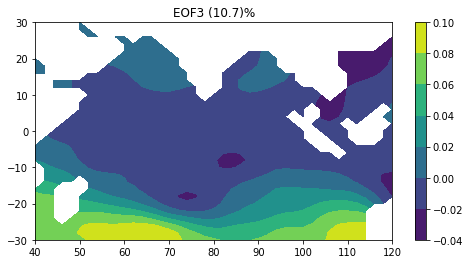

In [ ]:
# Analysis for the IOB mode
dfa=getmyssta()
dfa=seasonaverage(dfa,'MAM')

# Compute and plot EOF1
dfas=dfa.sel(lat=slice(-30,30),lon=slice(40,120))
eofs,pcas,exp_var=getpca2d(dfas)

# Compute index 
index=dfa.sel(lon=slice(40,120),lat=slice(-30,30)).mean("lon").mean("lat")

#####

# Plot SST covariance map with index similar to panel a
fig=plt.figure(None,figsize=(6,4))
plt.contourf(dfa.lon,dfa.lat,xr.cov(dfa,index,dim='time'),cmap='coolwarm')
plt.colorbar()
plt.title('SST spatial pattern (covariance with index)')

# Plot index and PC1 (standardized) as in panel b
fig=plt.figure(None,figsize=(12,3))
plt.axhline(y=0,color='k',linestyle='--')
plt.plot(dfa.time,index/np.nanstd(index),label='index')
plt.plot(dfa.time,pcas[:,0]/np.nanstd(pcas[:,0]),label='EOF1')# standardized means divide by std
plt.legend(loc=2)
plt.margins(x=0)
plt.title('temporal evolution from several metrics')
plt.ylabel('Corr='+ str(np.round(np.corrcoef(index,pcas[:,0])[1][0],2)) )

# Plot 3 first EOFs
for i in [1,2,3]:
  ploteof2d(i,eofs,exp_var,dfas)

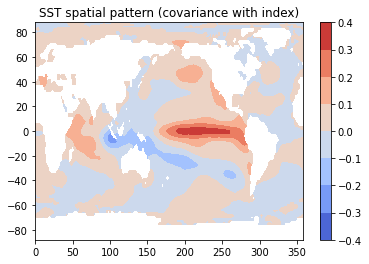

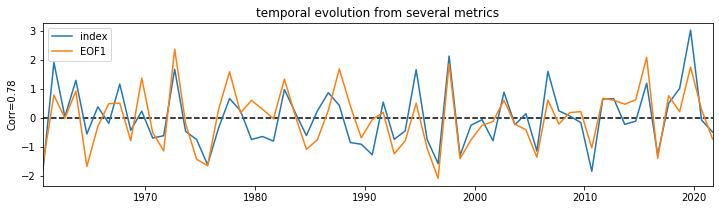

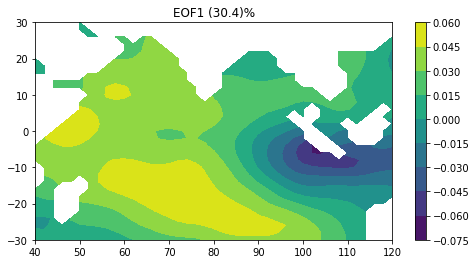

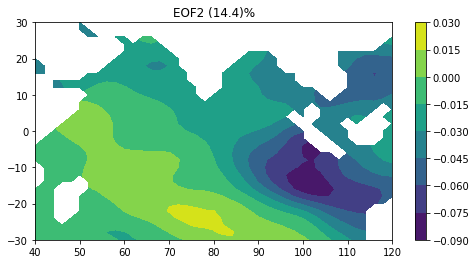

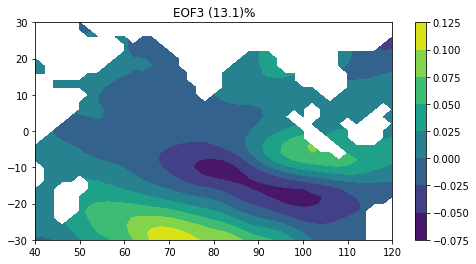

In [ ]:
# Analysis for the IOD mode
dfa=getmyssta()
dfa=seasonaverage(dfa,'SON')

# Compute and plot EOF1
dfas=dfa.sel(lat=slice(-30,30),lon=slice(40,120))
eofs,pcas,exp_var=getpca2d(dfas)

# Compute index 
index=dfa.sel(lon=slice(50,70),lat=slice(-10,10)).mean("lon").mean("lat")-\
dfa.sel(lon=slice(90,110),lat=slice(-10,0)).mean("lon").mean("lat")

#####

# Plot SST covariance map with index similar to panel a
fig=plt.figure(None,figsize=(6,4))
plt.contourf(dfa.lon,dfa.lat,xr.cov(dfa,index,dim='time'),cmap='coolwarm')
plt.colorbar()
plt.title('SST spatial pattern (covariance with index)')

# Plot index and PC1 (standardized) as in panel b
fig=plt.figure(None,figsize=(12,3))
plt.axhline(y=0,color='k',linestyle='--')
plt.plot(dfa.time,index/np.nanstd(index),label='index')
plt.plot(dfa.time,pcas[:,0]/np.nanstd(pcas[:,0]),label='EOF1')# standardized means divide by std
plt.legend(loc=2)
plt.margins(x=0)
plt.title('temporal evolution from several metrics')
plt.ylabel('Corr='+ str(np.round(np.corrcoef(index,pcas[:,0])[1][0],2)) )

# Plot 3 first EOFs
for i in [1,2,3]:
  ploteof2d(i,eofs,exp_var,dfas)


For the AZM and AMM below the longitude axis is cut so we are not computing the exact metrics. We could remedy this by recentering the data on the correct longitude (not shown here). 

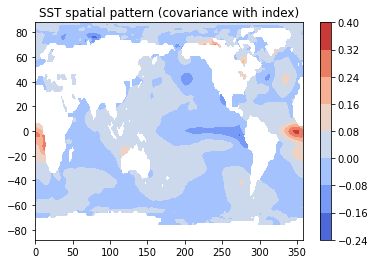

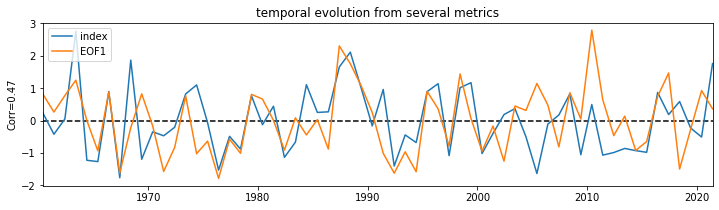

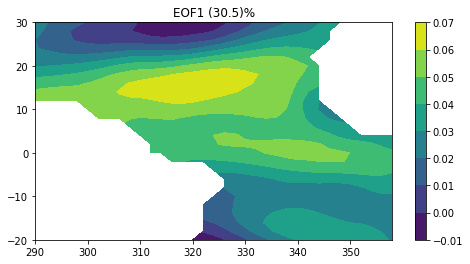

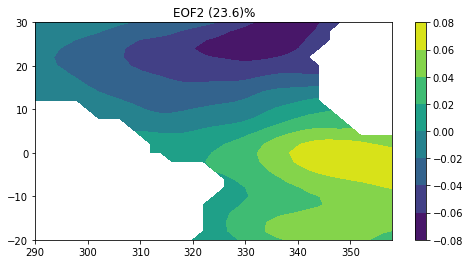

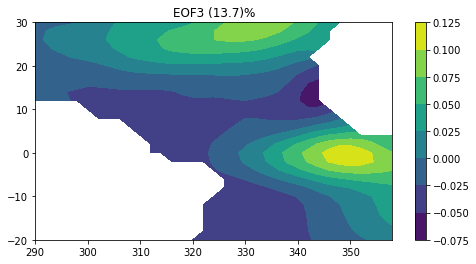

In [ ]:
# Analysis for the AZM mode
dfa=getmyssta()
dfa=seasonaverage(dfa,'JJA')

# Compute and plot EOF1
dfas=dfa.sel(lat=slice(-20,30),lon=slice(290,360))
eofs,pcas,exp_var=getpca2d(dfas)

# Compute index 
index=dfa.sel(lon=slice(340,360),lat=slice(-3,3)).mean("lon").mean("lat")

#####

# Plot SST covariance map with index similar to panel a
fig=plt.figure(None,figsize=(6,4))
plt.contourf(dfa.lon,dfa.lat,xr.cov(dfa,index,dim='time'),cmap='coolwarm')
plt.colorbar()
plt.title('SST spatial pattern (covariance with index)')

# Plot index and PC1 (standardized) as in panel b
fig=plt.figure(None,figsize=(12,3))
plt.axhline(y=0,color='k',linestyle='--')
plt.plot(dfa.time,index/np.nanstd(index),label='index')
plt.plot(dfa.time,pcas[:,0]/np.nanstd(pcas[:,0]),label='EOF1')# standardized means divide by std
plt.legend(loc=2)
plt.margins(x=0)
plt.title('temporal evolution from several metrics')
plt.ylabel('Corr='+ str(np.round(np.corrcoef(index,pcas[:,0])[1][0],2)) )

# Plot 3 first EOFs
for i in [1,2,3]:
  ploteof2d(i,eofs,exp_var,dfas)


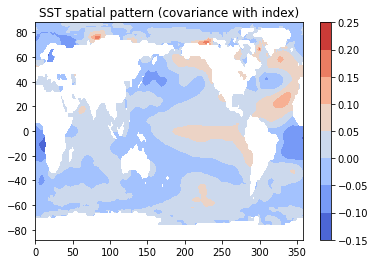

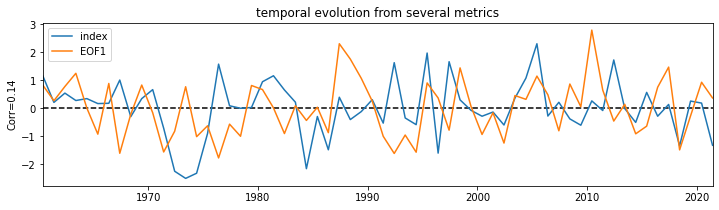

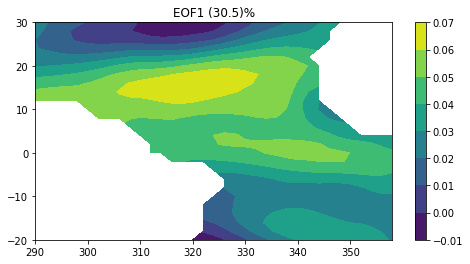

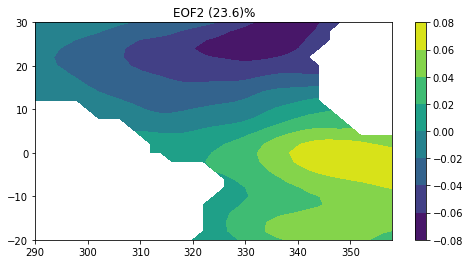

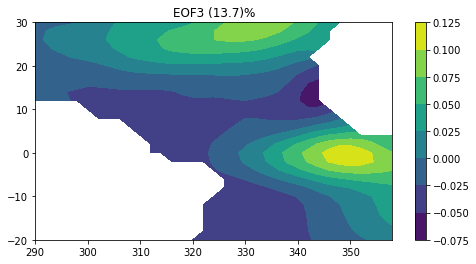

In [ ]:
# Analysis for the AMM mode
dfa=getmyssta()
dfa=seasonaverage(dfa,'JJA')

# Compute and plot EOF1
dfas=dfa.sel(lat=slice(-20,30),lon=slice(290,360))
eofs,pcas,exp_var=getpca2d(dfas)

# Compute index 
index=dfa.sel(lon=slice(300,340),lat=slice(5,30)).mean("lon").mean("lat")-\
dfa.sel(lon=slice(335,360),lat=slice(-20,-5)).mean("lon").mean("lat")

#####

# Plot SST covariance map with index similar to panel a
fig=plt.figure(None,figsize=(6,4))
plt.contourf(dfa.lon,dfa.lat,xr.cov(dfa,index,dim='time'),cmap='coolwarm')
plt.colorbar()
plt.title('SST spatial pattern (covariance with index)')

# Plot index and PC1 (standardized) as in panel b
fig=plt.figure(None,figsize=(12,3))
plt.axhline(y=0,color='k',linestyle='--')
plt.plot(dfa.time,index/np.nanstd(index),label='index')
plt.plot(dfa.time,pcas[:,0]/np.nanstd(pcas[:,0]),label='EOF1')# standardized means divide by std
plt.legend(loc=2)
plt.margins(x=0)
plt.title('temporal evolution from several metrics')
plt.ylabel('Corr='+ str(np.round(np.corrcoef(index,pcas[:,0])[1][0],2)) )

# Plot 3 first EOFs
for i in [1,2,3]:
  ploteof2d(i,eofs,exp_var,dfas)
